# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import train_dynamics
from dynamics.base_dynamics import BaseDynamics, DynamicsConfig
from dynamics.generic_dynamics import GenericDynamics
from network.generic_network import GenericNetwork
from config import (State, NetWeights, MonteCarloStates,
                    LearningRateConfig, BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

#sns.set_palette('bright')

2020-09-24 16:52:14,407:INFO:Number of devices: 1


In [16]:
sns.set(context="notebook")
plt.style.use("/Users/saforem2/.config/matplotlib/stylelib/molokai.mplstyle")

## Helper functions

<IPython.core.display.Javascript object>


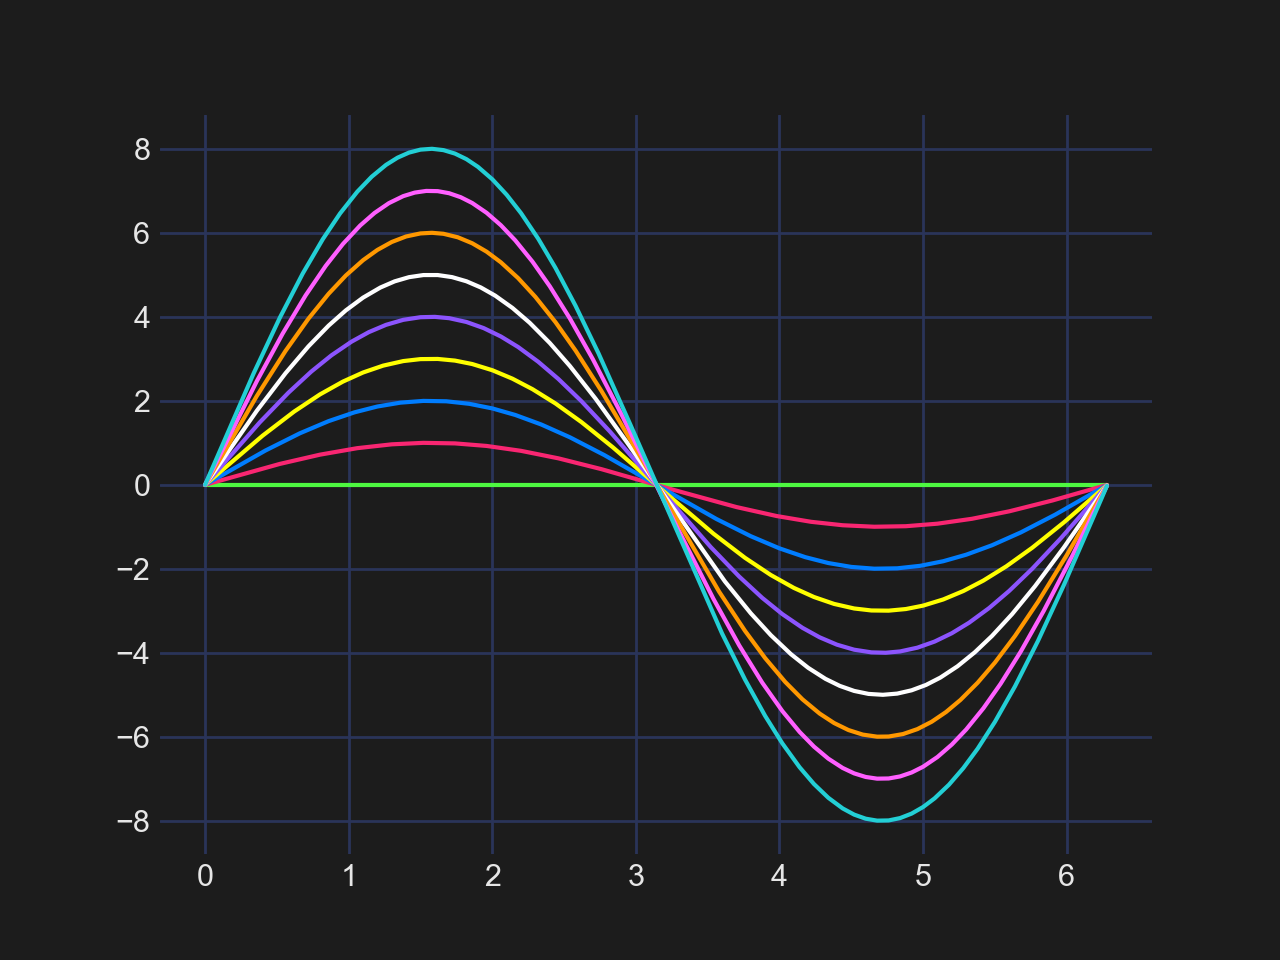

In [20]:
x = np.arange(0, 2*np.pi, 0.02)
y_arr = [i * np.sin(x) for i in range(9)]
fig, ax = plt.subplots()
for y in y_arr:
    _ = ax.plot(x, y)

In [21]:
from config import LearningRateConfig, NetworkConfig

def identity(x):
    return x

def get_dynamics(flags):
    """Return `GenericDynamics` object, initialized from `flags`."""
    config = DynamicsConfig(eps=flags.eps,
                            num_steps=flags.num_steps,
                            aux_weight=flags.aux_weight,
                            loss_scale=0.1,
                            hmc=flags.hmc,
                            eps_fixed=flags.eps_fixed,
                            model_type=flags.model_type)


    net_config = NetworkConfig(units=flags.units,
                               dropout_prob=flags.dropout_prob,
                               name=flags.network_name,
                               activation_fn=flags.activation_fn)

    lr_config = LearningRateConfig(flags.lr_init,
                                   decay_steps=flags.decay_steps,
                                   decay_rate=flags.decay_rate,
                                   warmup_steps=flags.warmup_steps)

    dynamics = GenericDynamics(params=flags,
                               config=config,
                               lr_config=lr_config,
                               normalizer=identity,
                               network_config=net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
    
    return dynamics

In [22]:
import utils.file_io as io
from utils.distributions import contour_potential

#%matplotlib inline

def plot_chains(dirs, x_arr, potential_fn, label=None, cmap='rainbow'):
    figs_dir = os.path.join(dirs.log_dir, 'figures')
    io.check_else_make_dir(figs_dir)

    x_arr = tf.convert_to_tensor(x_arr).numpy()

    for chain in range(4):
        fig, ax = plt.subplots()
        xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
        #sns.kdeplot(*xy, ax=ax)
        #grid = xy.reshape(2, -1).T
        #Z = np.exp(-POTENTIAL_FN(grid))
        #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
        #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
        #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
        xlim = 5
        ylim = 5
        _ = contour_potential(POTENTIAL_FN, ax=ax, cmap=cmap, xlim=xlim, ylim=ylim)
        _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                    color='white', label='l2hmc samples')
        #_ = ax.legend(markerscale=5., loc='best')
        _ = ax.set_xlim((-xlim, xlim))
        _ = ax.set_ylim((-ylim, ylim))
        out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.show()

In [23]:
def plot_density_estimation(potential_fn, x_l2hmc, x_hmc,
                            title=None, cmap=None, num_plots=5):
    def _format_arr(x):
        x = np.array(x)
        n = x.shape[0]
        therm = 2 * n // 10  # Drop first 20% of samples (thermalization)
        return x[therm:]
    
    x_l2hmc = _format_arr(x_l2hmc)
    x_hmc = _format_arr(x_hmc)
    
    for idx in range(num_plots):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
        _ = contour_potential(potential_fn, title=title, ax=axes[0], cmap=cmap)
        _ = sns.kdeplot(x_l2hmc[:, idx, 0], x_l2hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[1])
        _ = sns.kdeplot(x_hmc[:, idx, 0], x_hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[2])
        _ = axes[1].set_title('L2HMC samples')
        _ = axes[2].set_title('HMC samples')
        plt.tight_layout()
        
    return fig, axes

### Plot examples of (toy) target distributions:

In [24]:
%matplotlib notebook

<IPython.core.display.Javascript object>


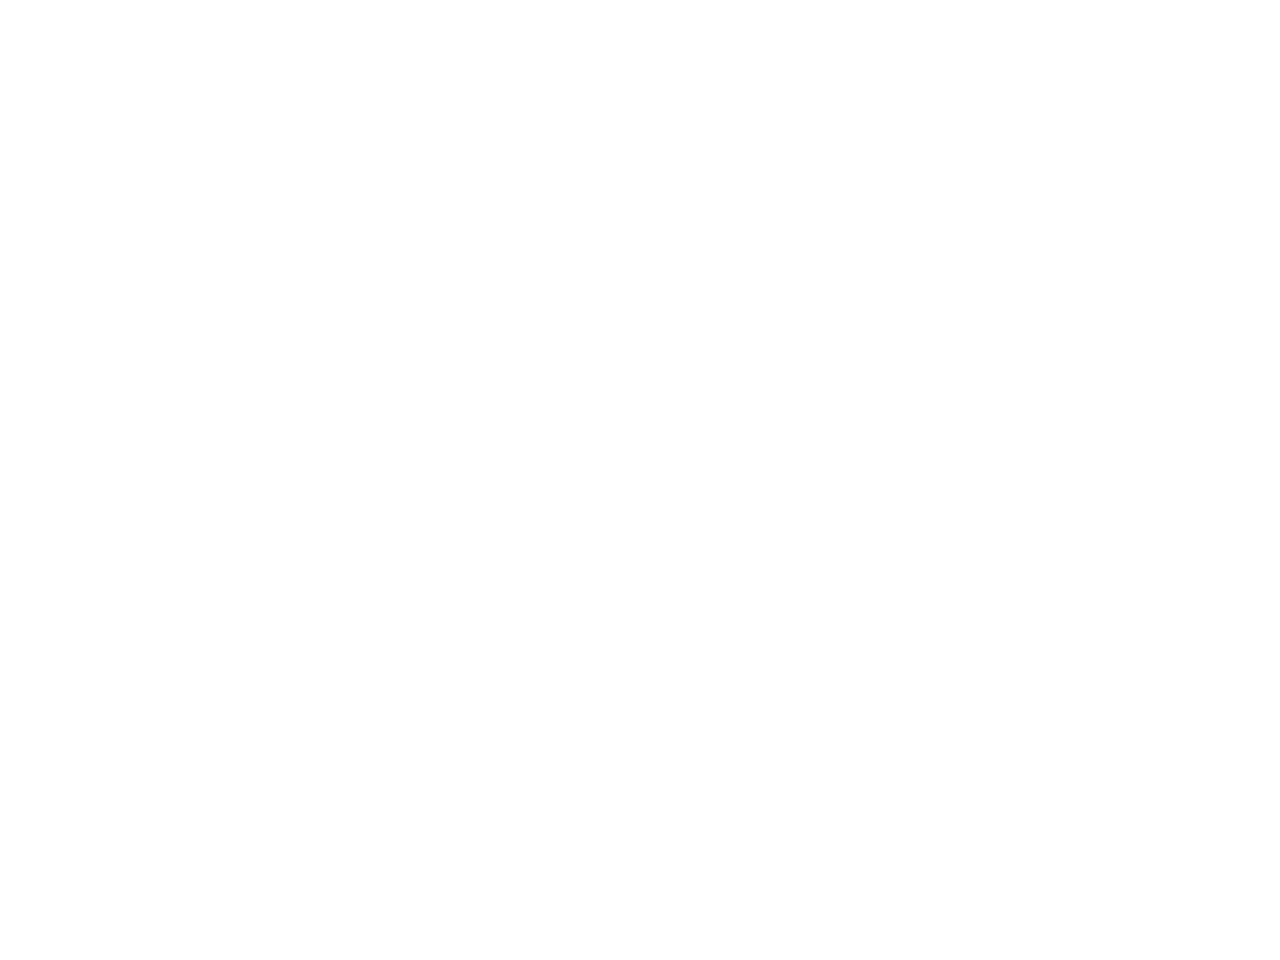

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons', 'sin', 'sin_hard', 'sin_harder']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
potentials_dict = {}
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}', cmap='rocket')
    ax.facecolor = '#1c1c1c'
    fig = plt.gcf()
    fig.facecolor = '#1c1c1c'
    potentials_dict[names[idx]] = p_fn
    

plt.grid(True)
plt.show()

In [28]:
%matplotlib notebook
plt.style.use('~/.config/matplotlib/stylelib/molokai.mplstyle')

<IPython.core.display.Javascript object>


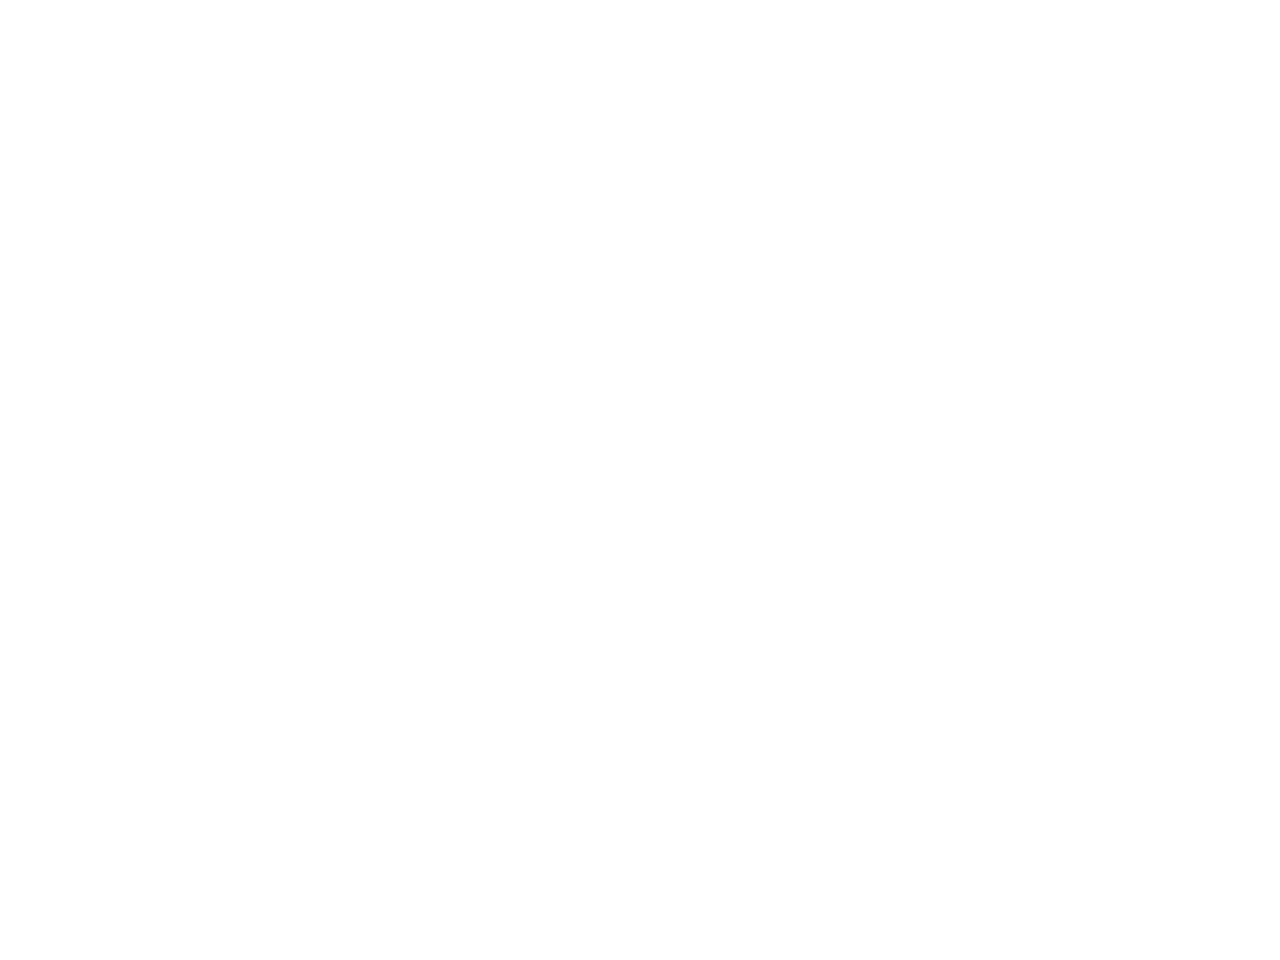

<IPython.core.display.Javascript object>


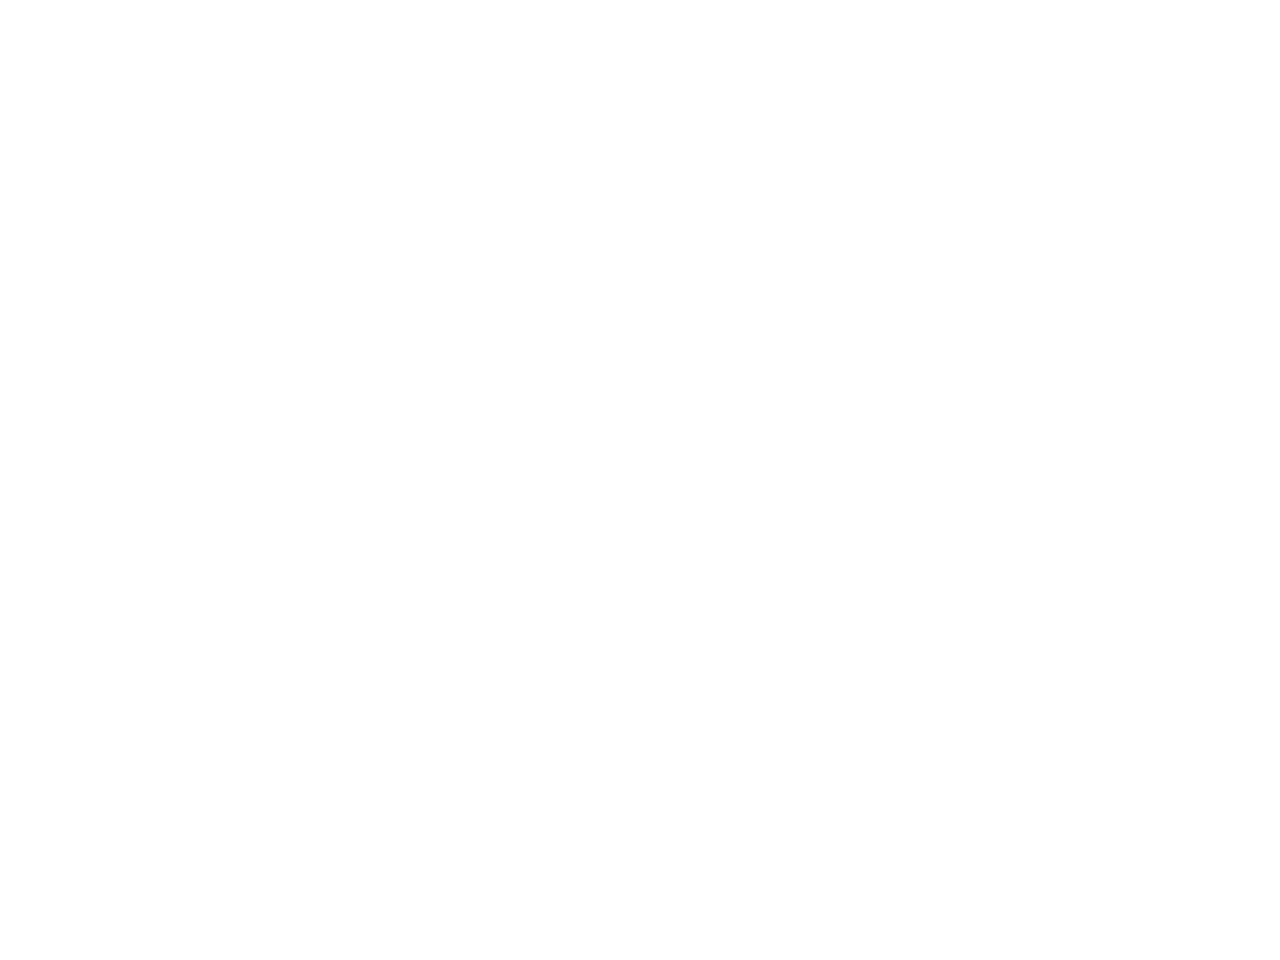

In [27]:
from utils.distributions import GaussianFunnel, RoughWell

funnel = GaussianFunnel()
funnel_potential = funnel.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(funnel_potential, ax=ax, title=f'Gaussian Funnel Potential')
plt.show()

rough_well = RoughWell(dim=2, eps=0.1, easy=True)
rough_well_hard = RoughWell(dim=2, eps=0.1, easy=False)

rw_potential = rough_well.get_energy_function()
rwh_potential = rough_well_hard.get_energy_function()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()
ax0 = contour_potential(rw_potential, ax=axes[0], cmap='rocket', title='Rough Well Potential')
ax1 = contour_potential(rwh_potential, ax=axes[1], cmap='rocket', title='Rough Well Potential (Hard)')
ax0.set_aspect('equal')
ax1.set_aspect('equal')

potentials_dict.update({
    'funnel': funnel_potential,
    'rough_well': rw_potential,
    'rough_well_hard': rwh_potential,
})

In [29]:
from utils.distributions import GaussianMixtureModel, meshgrid
import tensorflow_probability as tfp
tfd = tfp.distributions
floatx = tf.keras.backend.floatx()


def make_gmm_model(mus, sigmas, pis):
    def to_tensors(x):
        return (tf.convert_to_tensor(i, dtype=floatx) for i in x)
    
    mus, sigmas, pis = to_tensors([mus, sigmas, pis])
    gmm = tfd.Mixture(
        cat=tfd.Categorical(probs=pis),
        components=[
            tfd.MultivariateNormalDiag(loc=m, scale_diag=s)
            for m, s in zip(mus, sigmas)
        ]
    )
    
    def potential(x):
        return -1. * gmm.log_prob(x)
    
    #model = GaussianMixtureModel(mus, sigmas, pis) 
    #potential_fn = lambda x: -1. * model.dist.log_prob(x)
    #return model, potential_fn
    
    return gmm, potential

Gaussian mixture models:

 1. 2-Component mixture: 
 $$x \sim p(x) \equiv \frac{1}{2}\mathcal{N}(\vec{x}_{0}, \Sigma_{0}) + \frac{1}{2}\mathcal{N}(\vec{x}_{1}, \Sigma_{1})$$
 2. $4\times 4$ Lattice of Gaussians: 
 $$x\sim\mathcal{N}(\vec{x}_{ij}, \Sigma_{ij})$$

<IPython.core.display.Javascript object>


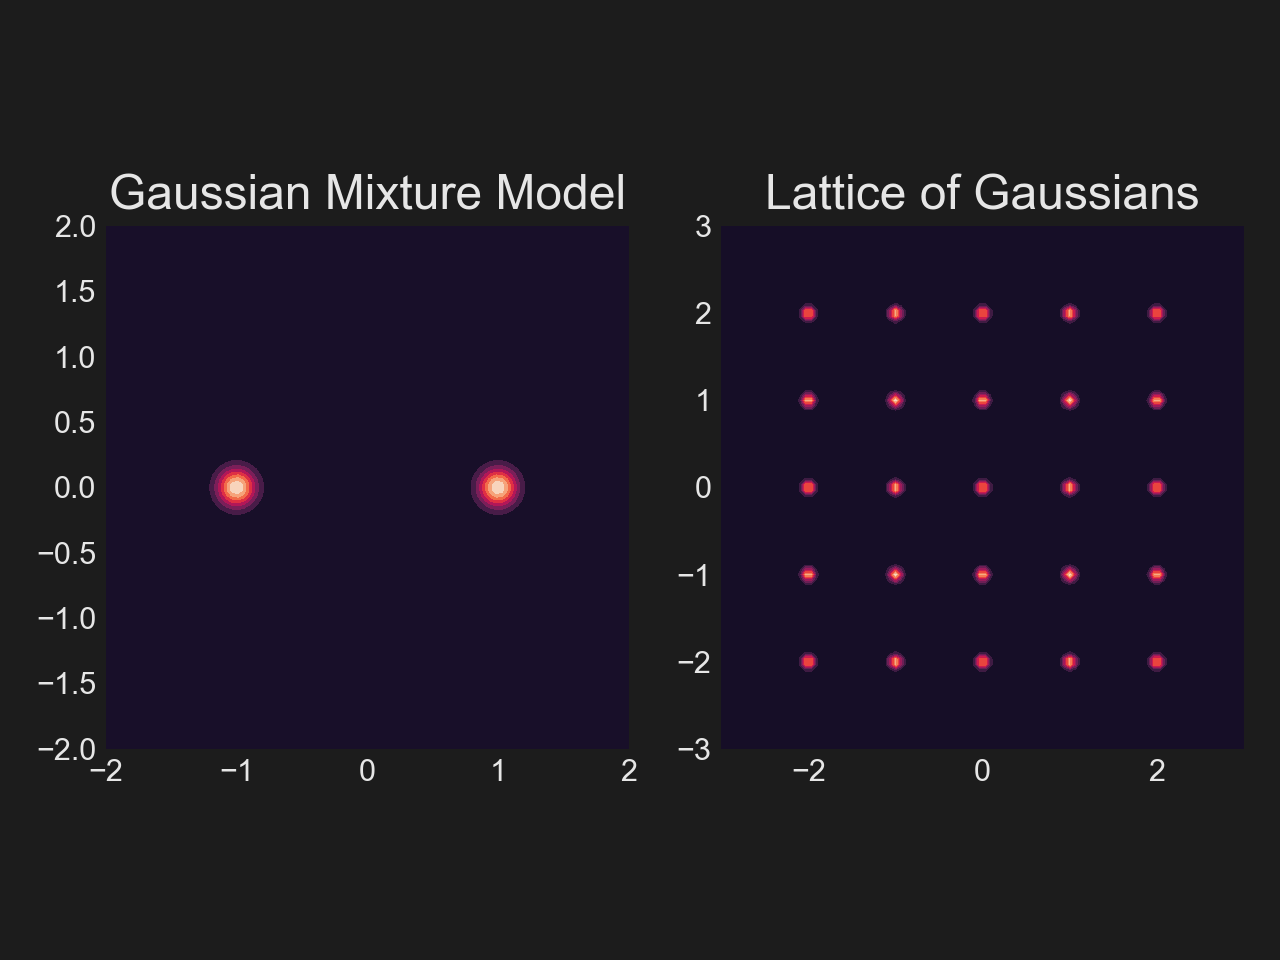

In [32]:
# ==== Mixture of two components
mus = [(-1., 0), (1., 0)]
sigmas = [0.1 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm, gmm_potential = make_gmm_model(mus, sigmas, pis)


# ==== 4x4 Lattice of Gaussians
# xy locations of each component
mus = [(-2, -2), (-2, -1), (-2, +0), (-2, +1), (-2, +2),
       (-1, -2), (-1, -1), (-1, +0), (-1, +1), (-1, +2),
       (+0, -2), (+0, -1), (+0, +0), (+0, +1), (+0, +2),
       (+1, -2), (+1, -1), (+1, +0), (+1, +1), (+1, +2),
       (+2, -2), (+2, -1), (+2, +0), (+2, +1), (+2, +2)]

sigmas = [0.05 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm_latt, gmm_latt_potential = make_gmm_model(mus, sigmas, pis)


potentials_dict.update({
    'gmm': gmm_potential,
    'lattice_of_gaussians': gmm_latt_potential,
})


# ==== Plot contours of both potentials
fig, axes = plt.subplots(ncols=2)
axes = axes.flatten()

ax0 = contour_potential(gmm_potential, ax=axes[0],
                        cmap='rocket', xlim=2, ylim=2,
                        title='Gaussian Mixture Model')

ax1 = contour_potential(gmm_latt_potential, ax=axes[1],
                        cmap='rocket', xlim=3, ylim=3,
                        title='Lattice of Gaussians')
    
_ = [ax.set_aspect('equal') for ax in axes]

## Define parameters of the model and target distribution

In [37]:
import utils.file_io as io
import datetime

LOGS_DIR = os.path.abspath('../../logs')

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE = 'lattice_of_gaussians'
POTENTIAL_FN = potentials_dict[MODEL_TYPE]

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')

log_dir = os.path.join(LOGS_DIR, f'{MODEL_TYPE}', date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)
    
io.check_else_make_dir(log_dir)


flags = AttrDict({
    'profiler': False,
    'xdim': 2,
    'eps': 0.1,
    'aux_weight': 0.0,
    'loss_scale': 0.1,
    'batch_size': 256,
    'num_steps': 10,
    'beta_init': 0.05,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 0,
    'lr_init': 1e-3,
    'train_steps': 10000,
    'clip_val': 1.0,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 10,
    'warmup_steps': 1000,
    'print_steps': 10,
    'units': [256, 256],
    'hmc': False,
    'eps_fixed': False,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

2020-09-24 18:25:22,407:INFO:Number of devices: 1
2020-09-24 18:25:43,243:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-182543


## Train

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [13]:
flags.hmc_steps = 10000

x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = LearningRateConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict({k: v for k, v in flags.items()})
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 10000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_fixed=flags.eps_fixed,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = io.setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    flags.eps = hmc_dynamics.eps.numpy()

2020-09-23 13:24:38,439:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc
2020-09-23 13:24:38,440:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/train_data
2020-09-23 13:24:38,441:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/checkpoints
2020-09-23 13:24:38,442:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/summaries
2020-09-23 13:24:38,442:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/dynamics_configs
2020-09-23 13:24:38,444:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/FLAGS.z.
2020-09-23 13:24:39,142:INFO:************************************************************************************************************************
2020-09-23 13:24:53,470:INFO:Compiled `

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000   0.01945      11.66       0.9986      0.1018       0.05         0      
    10/10000   0.01733      0.5047      0.9987      0.1058       0.05         0      
    20/10000   0.01655      0.5258      0.9983      0.1097       0.05         0      
    30/10000   0.01535      0.6733      0.9983      0.1116       0.05         0      
    40/10000   0.01621      2.341       0.9979      0.1152       0.05         0      
    50/10000    0.0158      0.496       0.9984      0.1182       0.05         0      
    60/10000   0.01646      0.0116      0.9976      0.1192       0.05         0      
    70/10000   0.02061     -0.8578      0.9978      0.1229       0.05         0      
    80/10000   0.01641     -0.5742      0.9981      0.122

   900/10000   0.01852      -2.298      0.9933      0.1885       0.05         0      
   910/10000   0.01556      -5.236      0.9907      0.1893       0.05         0      
   920/10000   0.01808      -4.703      0.992       0.1929       0.05         0      
   930/10000   0.01971      -5.762      0.9906      0.2012       0.05         0      
   940/10000   0.01564      -5.386      0.9913      0.2014       0.05         0      
   950/10000    0.0155      -4.68       0.9924      0.2002       0.05         0      
   960/10000   0.01574      -5.252      0.992       0.1997       0.05         0      
   970/10000   0.01548      -4.597      0.9941      0.1988       0.05         0      
   980/10000   0.01782      -4.563      0.9912      0.1991       0.05         0      
   990/10000    0.0167     -0.9774      0.9911      0.1984       0.05         0      
Saving configs from rank 0 to: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/train_data/x_rank0.z.
----------

  1780/10000   0.02754      -7.766      0.9892      0.2367       0.05         0      
  1790/10000   0.02626      -7.03       0.9885      0.2368       0.05         0      
  1800/10000   0.02481      -7.696      0.9864      0.2374       0.05         0      
  1810/10000    0.0261      -6.466      0.9882      0.2373       0.05         0      
  1820/10000   0.02493      -4.275      0.9878      0.2374       0.05         0      
  1830/10000   0.02362      -6.001      0.9898      0.2431       0.05         0      
  1840/10000    0.0247      -6.886      0.9875      0.2488       0.05         0      
  1850/10000   0.02806      -1.823      0.9853      0.2486       0.05         0      
  1860/10000   0.02304      -7.772      0.9877      0.2445       0.05         0      
  1870/10000   0.02123      -6.531      0.9866      0.2433       0.05         0      
  1880/10000   0.02286      -7.724      0.9892      0.2432       0.05         0      
  1890/10000    0.0256      -7.329      0.9891      0.

  2660/10000   0.02514      -8.479      0.988       0.265        0.05         0      
  2670/10000   0.02473      -8.278      0.987       0.2649       0.05         0      
  2680/10000   0.02363      -7.735      0.9861      0.2644       0.05         0      
  2690/10000   0.02569      -8.329      0.9864      0.2642       0.05         0      
  2700/10000   0.02506      -8.521      0.9873      0.2634       0.05         0      
  2710/10000    0.027       -8.395      0.9855      0.2635       0.05         0      
  2720/10000   0.02694      -8.206      0.9865      0.2627       0.05         0      
  2730/10000   0.02302      -7.316      0.9886      0.2628       0.05         0      
  2740/10000   0.02379      -9.365      0.9875      0.263        0.05         0      
  2750/10000    0.0233      -8.42       0.9853      0.263        0.05         0      
  2760/10000   0.02366      -8.137      0.9844      0.2632       0.05         0      
  2770/10000   0.02288      -8.134      0.9842      0.

  3540/10000   0.02204      -9.697      0.9846      0.2822       0.05         0      
  3550/10000   0.02244      -8.161      0.9845      0.2826       0.05         0      
  3560/10000   0.02314      -9.003      0.9824      0.2828       0.05         0      
  3570/10000   0.02578      -5.033      0.9846      0.2831       0.05         0      
  3580/10000   0.02526      -8.864      0.9831      0.2838       0.05         0      
  3590/10000   0.02527      -9.169      0.9854      0.2847       0.05         0      
  3600/10000   0.02757      -9.617      0.9833      0.2854       0.05         0      
  3610/10000   0.03073      -9.042      0.9835      0.2854       0.05         0      
  3620/10000   0.02917      -9.343      0.985       0.2855       0.05         0      
  3630/10000   0.02812      -8.943      0.9803      0.286        0.05         0      
  3640/10000   0.02825      -9.641      0.9834      0.287        0.05         0      
  3650/10000   0.03153      -9.317      0.9815      0.

  4450/10000   0.02735      -8.324      0.9796      0.3043       0.05         0      
  4460/10000   0.02623      -9.321      0.9807      0.3045       0.05         0      
  4470/10000   0.02685      -9.828      0.9843      0.3047       0.05         0      
  4480/10000   0.02889      -10.08      0.9796      0.3051       0.05         0      
  4490/10000   0.02536      -9.634      0.9838      0.3053       0.05         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4500/10000   0.02571      -9.417      0.9818      0.3055       0.05         0      
  4510/10000   0.02537      -9.702      0.9801      0.3057       0.05         0      
  4520/10000   0.02621      -4.728      0.9785      0.3055       0.05         0      
  4530/10000   0.02432      -9.179      0.9826      0.305

  5330/10000   0.03289      -11.16      0.9735      0.3475       0.05         0      
  5340/10000   0.02896      -10.4       0.9757      0.3493       0.05         0      
  5350/10000   0.02886      -10.33      0.9749      0.3502       0.05         0      
  5360/10000   0.02688      -10.62      0.9756      0.3506       0.05         0      
  5370/10000   0.02772      3.755       0.9721      0.3511       0.05         0      
  5380/10000   0.02718      -9.828      0.9777      0.3544       0.05         0      
  5390/10000   0.02506      -10.97      0.9737      0.3544       0.05         0      
  5400/10000   0.02729      -9.407      0.973       0.3545       0.05         0      
  5410/10000   0.02385      -10.73      0.9756      0.3541       0.05         0      
  5420/10000   0.02363      -10.79      0.9725      0.3542       0.05         0      
  5430/10000   0.02253      -10.11      0.9779      0.3539       0.05         0      
  5440/10000   0.02238      -11.12      0.9736      0.

  6210/10000   0.02635      -10.28      0.968       0.3502       0.05         0      
  6220/10000   0.02514      -10.7       0.974       0.3506       0.05         0      
  6230/10000    0.0245      -11.3       0.9744      0.3508       0.05         0      
  6240/10000   0.02907      -10.42      0.9763      0.3511       0.05         0      
  6250/10000   0.02642      -10.78      0.9796      0.3514       0.05         0      
  6260/10000   0.02658      -11.18      0.9806      0.3502       0.05         0      
  6270/10000   0.02523      -10.19      0.9763      0.3497       0.05         0      
  6280/10000   0.02533      -10.72      0.9783      0.3496       0.05         0      
  6290/10000   0.02347      -10.41      0.9797      0.3496       0.05         0      
  6300/10000   0.02267      -10.2       0.9758      0.3498       0.05         0      
  6310/10000   0.02469      -10.4       0.975       0.3499       0.05         0      
  6320/10000   0.02756      -11.47      0.9761       0

  7090/10000   0.02236      -12.15      0.976       0.344        0.05         0      
  7100/10000   0.02265      -10.56      0.9735      0.344        0.05         0      
  7110/10000   0.02269      -10.89      0.9732      0.344        0.05         0      
  7120/10000   0.02376      -10.9       0.9743      0.344        0.05         0      
  7130/10000   0.02441      -10.37      0.9796      0.3443       0.05         0      
  7140/10000   0.02363      -8.908      0.9758      0.3438       0.05         0      
  7150/10000   0.02238      -10.42      0.9763      0.3411       0.05         0      
  7160/10000   0.02195      -10.41       0.98       0.3406       0.05         0      
  7170/10000   0.02322      -11.41      0.9782      0.3413       0.05         0      
  7180/10000   0.02203      -10.84      0.9761      0.3414       0.05         0      
  7190/10000   0.02267      -10.92      0.9772      0.3413       0.05         0      
  7200/10000   0.02279      -10.93      0.9781      0.

  8010/10000    0.0293      -9.748      0.9783      0.336        0.05         0      
  8020/10000   0.02994      -11.14      0.9722      0.3383       0.05         0      
  8030/10000   0.02468      -10.8       0.9787      0.339        0.05         0      
  8040/10000   0.02554      -9.39       0.9793      0.3406       0.05         0      
  8050/10000   0.02755      -11.37      0.9763      0.3418       0.05         0      
  8060/10000   0.02657      -11.43      0.9783      0.3403       0.05         0      
  8070/10000   0.02703      -11.21      0.9789      0.3396       0.05         0      
  8080/10000   0.02936      -10.54      0.9747      0.3395       0.05         0      
  8090/10000   0.03052      -10.52      0.9725      0.3396       0.05         0      
  8100/10000   0.02486      -11.06      0.9727      0.3412       0.05         0      
  8110/10000   0.02541      -11.11      0.9769      0.3376       0.05         0      
  8120/10000    0.0256      -9.989      0.9764      0.

  8940/10000   0.02483      -10.53      0.9728      0.3456       0.05         0      
  8950/10000    0.0249      -8.707      0.9756      0.347        0.05         0      
  8960/10000   0.02456      -12.62      0.9773      0.3472       0.05         0      
  8970/10000   0.02508      -11.46      0.9768      0.3477       0.05         0      
  8980/10000   0.02545      -11.67      0.9748      0.3472       0.05         0      
  8990/10000   0.02398      -11.48      0.9787      0.3486       0.05         0      
Saving configs from rank 0 to: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-132431/training_hmc/train_data/x_rank0.z.
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  9000/10000    0.0238      -10.8       0.9764      0.3498       0.05         0      
  9010/10000 

  9820/10000   0.02383      -10.89      0.9726      0.3397       0.05         0      
  9830/10000   0.02455      -10.02      0.9786      0.3399       0.05         0      
  9840/10000   0.02256      -10.32      0.9774      0.3401       0.05         0      
  9850/10000   0.02265      -9.156      0.9795      0.3403       0.05         0      
  9860/10000   0.02509      -10.4       0.9776      0.3409       0.05         0      
  9870/10000   0.02442      -8.781      0.9729      0.3411       0.05         0      
  9880/10000   0.03964      -10.6       0.979       0.3411       0.05         0      
  9890/10000   0.02393      -11.21      0.9748      0.3411       0.05         0      
  9900/10000   0.02324      -10.91      0.979       0.3472       0.05         0      
  9910/10000   0.02707      -10.33      0.9773      0.3498       0.05         0      
  9920/10000   0.02691      -10.86      0.9753      0.3508       0.05         0      
  9930/10000   0.02939      -10.76      0.9773      0.

### Create `GenericDynamics` object

In [34]:
dynamics = get_dynamics(flags)

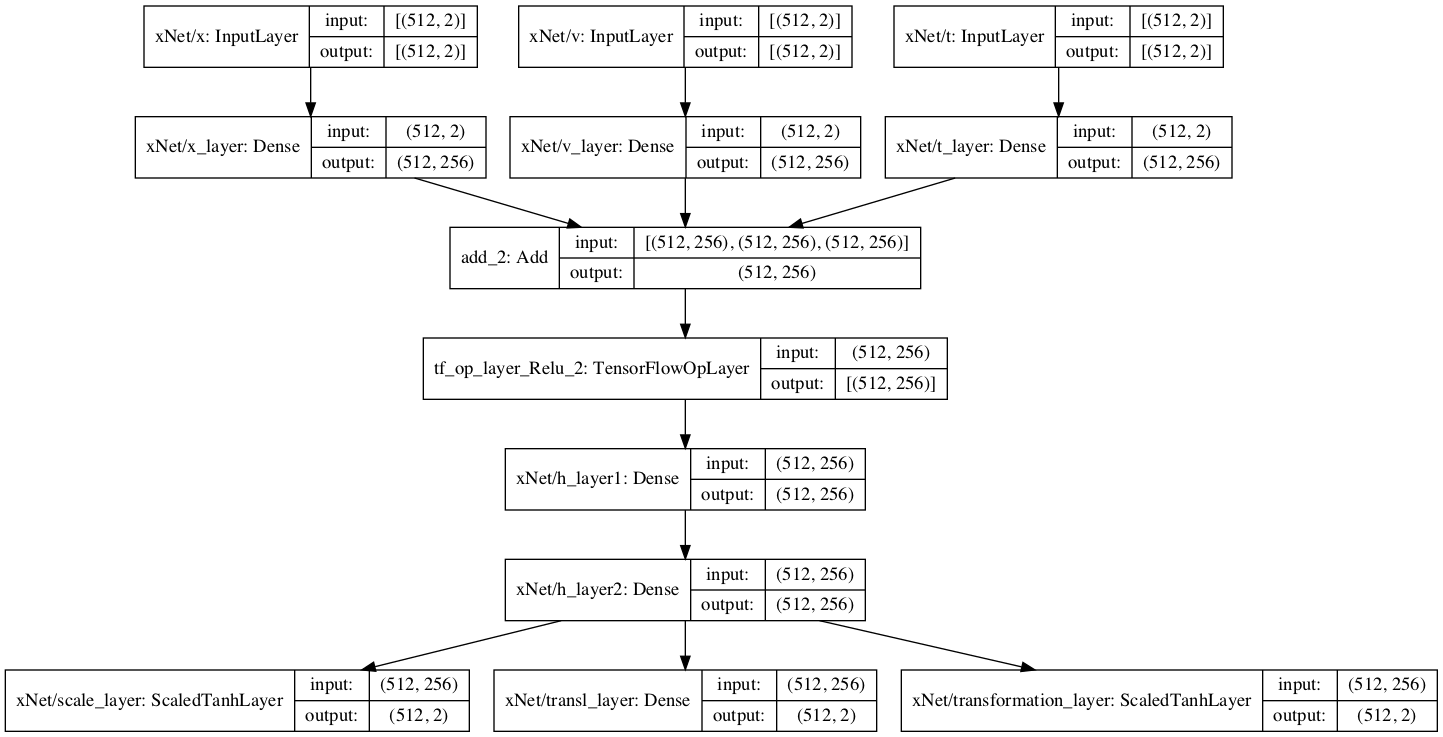

In [18]:
tf.keras.utils.plot_model(dynamics.xnet, show_shapes=True)

### Train L2HMC sampler using HMC sampler as starting point

In [35]:
flags.restore = False

In [36]:
dirs = io.setup_directories(flags)
x = tf.random.normal(dynamics.x_shape)
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

2020-09-24 16:59:38,927:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-165919/training
2020-09-24 16:59:38,928:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-165919/training/train_data
2020-09-24 16:59:38,929:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-165919/training/checkpoints
2020-09-24 16:59:38,929:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-165919/training/summaries
2020-09-24 16:59:38,930:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-165919/training/dynamics_configs
2020-09-24 16:59:38,931:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/lattice_of_gaussians/2020-09-24/2020-09-24-165919/training/FLAGS.z.
2020-09-24 16:59:46,053:INFO:**********************************************************************************

------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/10000    0.2127      1.911       0.7127      0.1013       0.05     -0.005168  
    10/10000    0.2359      47.18       0.5408      0.1046     0.05015     0.001967  
    20/10000    0.2342      180.9       0.3887      0.1096      0.0503    -0.004645  
    30/10000    0.2266      516.5       0.1688      0.1111     0.05045    -0.007272  
    40/10000    0.2644      816.3      0.04643      0.1141      0.0506    -0.005496  
    50/10000    0.2949      998.7     8.277e-06     0.1164     0.05075        0      
    60/10000    0.3201       1000         0         0.1164     0.05091        0      
    70/10000    0.3328       1000         0         0.1163     0.05106        0      
    80/10000    0.432        1000         0         0.116

KeyboardInterrupt: 

## Run inference

In [19]:
import utils.file_io as io

#dirs = io.setup_directories(flags)

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

2020-09-23 15:58:28,781:INFO:INFO:Checkpoint restored from: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-134002/training/checkpoints/ckpt-11


In [20]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-09-23 15:58:31,765:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-23/2020-09-23-134002/inference/summaries
2020-09-23 15:58:31,767:INFO:Running inference with:
 beta: 1.0
eps: -0.004576
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.04473       2027       0.3095    -0.004576       1       -0.005939  
    10/5000    0.04707       1250       0.3738    -0.004576       1       -0.004254  
    20/5000    0.04544       1181       0.4013    -0.004576       1       -0.001252  
    30/5000    0.04058       1212       0.4189    -0.004576       1       -0.0008909 
    40/5000    0.04335       1130       0.4329    -0.004576       1       0.0008605  
    50/5000    0.04278       1297       0.4583    -0.004576       1        0.002618  
    60/5000    0.04428       1227       0.4544    -0.004576       1        0.001372  
    70/5000    0.05059       1120       0.4803    -0.004576       1       0.0008969  
    80/5000    0.05624      991.6       0.4966    -0.004576       1        0.000772  
    90/5000    0.06898       1068       0.4659    -0.004576       1       0.0009657  
   100/5000    0.04973       1143       0.4746    -0.004576       1       -0.0008383 
   110/5000    0.05908       989        0.4909    -0.0

KeyboardInterrupt: 

In [44]:

hmc_flags = AttrDict(dict(flags))
#hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
###hmc_flags.train_steps = 10000
hmc_flags.logging_steps = hmc_flags.train_steps // 20
hmc_flags.beta_final = hmc_flags.beta_init
hmc_flags.compile = True
hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                            num_steps=hmc_flags.num_steps,
                            hmc=True,
                            eps_fixed=flags.eps_fixed,
                            model_type=MODEL_TYPE)
hmc_dynamics = GenericDynamics(params=hmc_flags,
                               config=hmc_config,
                               lr_config=dynamics.lr_config,
                               network_config=dynamics.net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
hmc_dynamics._parse_net_weights(NetWeights(0., 0., 0., 0., 0., 0.))
#hmc_dirs = setup_directories(hmc_flags, 'training_hmc')

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000
x_init = 1. + 0.2 * tf.random.normal(x.shape)
run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True, x=x_init)
    
writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

2020-09-11 04:20:14,677:INFO:Running inference with:
 beta: 1.0
eps: 0.1
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.008002     0.2158      0.994        0.1          1           0      
    10/5000    0.008012     11.54       0.9835       0.1          1           0      
    20/5000    0.007197     12.36       0.9839       0.1          1           0      
    30/5000    0.008413     18.76       0.9845       0.1          1           0      
    40/5000    0.008856     30.93       0.9846       0.1          1           0      
    50/5000    0.007646     15.62       0.9844       0.1          1           0      
    60/5000    0.006957     17.23       0.9861       0.1          1           0      
    70/5000    0.007383     17.13       0.9838       0.1          1           0      
    80/5000    0.007096     24.07       0.9848       0.1          1           0      
    90/5000    0.007502     20.99       0.9834       0.1          1           0      
   100/5000    0.007535     15.95       0.9843       0.1          1           0      
   110/5000    0.007485     9.761       0.9866       0

   960/5000    0.005682     25.66       0.9843       0.1          1           0      
   970/5000    0.006545     16.62       0.9827       0.1          1           0      
   980/5000    0.005805     18.88       0.9828       0.1          1           0      
   990/5000    0.005839     11.78       0.9834       0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.006296     39.05       0.9846       0.1          1           0      
  1010/5000    0.00587      14.85       0.9846       0.1          1           0      
  1020/5000    0.007572     22.64       0.9825       0.1          1           0      
  1030/5000    0.00625      28.84       0.9829       0.1          1           0      
  1040/5000    0.00754      16.68       0.9846       0.1 

  1890/5000    0.008704     14.64       0.9843       0.1          1           0      
  1900/5000    0.007675     12.66       0.9857       0.1          1           0      
  1910/5000    0.006692     20.26       0.9839       0.1          1           0      
  1920/5000    0.007894     14.77       0.9843       0.1          1           0      
  1930/5000    0.006969     15.85       0.9852       0.1          1           0      
  1940/5000    0.006599     12.26       0.9837       0.1          1           0      
  1950/5000    0.008161     15.04       0.9866       0.1          1           0      
  1960/5000    0.008711     18.77       0.9849       0.1          1           0      
  1970/5000    0.009078     18.52       0.9864       0.1          1           0      
  1980/5000    0.006879     15.39       0.9864       0.1          1           0      
  1990/5000    0.008778     15.59       0.9826       0.1          1           0      
------------------------------------------------------

  2840/5000    0.007004     21.62       0.9865       0.1          1           0      
  2850/5000    0.007808     13.92       0.9847       0.1          1           0      
  2860/5000    0.007122     14.85       0.9837       0.1          1           0      
  2870/5000    0.007697     9.967       0.9845       0.1          1           0      
  2880/5000    0.007195     16.32       0.9825       0.1          1           0      
  2890/5000    0.007322     18.51       0.9845       0.1          1           0      
  2900/5000    0.007353     10.96       0.9839       0.1          1           0      
  2910/5000    0.006306     20.18       0.9845       0.1          1           0      
  2920/5000    0.007513     9.518       0.9831       0.1          1           0      
  2930/5000    0.007283     16.14       0.9835       0.1          1           0      
  2940/5000    0.007185     17.85       0.9839       0.1          1           0      
  2950/5000    0.006672     19.48       0.9834       0

  3770/5000    0.005977     20.86       0.9844       0.1          1           0      
  3780/5000    0.006014     10.11       0.9821       0.1          1           0      
  3790/5000    0.005849     11.18       0.9841       0.1          1           0      
  3800/5000    0.006289     12.05       0.9836       0.1          1           0      
  3810/5000    0.005708     18.82       0.9842       0.1          1           0      
  3820/5000    0.005721     9.911       0.9841       0.1          1           0      
  3830/5000    0.006491     12.84       0.9848       0.1          1           0      
  3840/5000    0.006216     24.29       0.9833       0.1          1           0      
  3850/5000    0.006047     12.08       0.9816       0.1          1           0      
  3860/5000    0.006966      20.2       0.9818       0.1          1           0      
  3870/5000    0.005916      15.2       0.9819       0.1          1           0      
  3880/5000    0.006556     13.48       0.9854       0

  4700/5000    0.00665      15.04       0.9847       0.1          1           0      
  4710/5000    0.006165     28.82       0.9847       0.1          1           0      
  4720/5000    0.01391      27.27       0.985        0.1          1           0      
  4730/5000    0.00581      11.65       0.9842       0.1          1           0      
  4740/5000    0.006285     26.77       0.987        0.1          1           0      
  4750/5000    0.008654     25.72       0.9835       0.1          1           0      
  4760/5000    0.006871     11.68       0.9856       0.1          1           0      
  4770/5000    0.006387     18.33       0.9837       0.1          1           0      
  4780/5000    0.006208     15.89       0.9854       0.1          1           0      
  4790/5000    0.005944     15.76       0.984        0.1          1           0      
  4800/5000    0.006373     13.76       0.9877       0.1          1           0      
  4810/5000    0.006525      12.4       0.9843       0

In [23]:
hmc_dynamics._parse_net_weights(hmc_dynamics.net_weights)

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000

run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True)

writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

2020-09-08 18:30:45,410:INFO:Running inference with:
 beta: 1.0
eps: 0.1
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000    0.004675     -1.307      0.9974       0.1          1           0      
    10/5000    0.004267     23.68       0.998        0.1          1           0      
    20/5000    0.002914      2.02       0.998        0.1          1           0      
    30/5000    0.00293      7.258       0.9978       0.1          1           0      
    40/5000    0.003095      5.29       0.9982       0.1          1           0      
    50/5000    0.003071     2.145       0.998        0.1          1           0      
    60/5000    0.003259     2.518       0.9985       0.1          1           0      
    70/5000    0.002975     3.159       0.9982       0.1          1           0      
    80/5000    0.002915     3.567       0.9984       0.1          1           0      
    90/5000    0.002947     4.843       0.998        0.1          1           0      
   100/5000    0.002749     4.069       0.9983       0.1          1           0      
   110/5000    0.003135      1.93       0.998        0

   980/5000    0.003107     2.902       0.9979       0.1          1           0      
   990/5000    0.002503     1.533       0.998        0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000    0.002602     3.648       0.9985       0.1          1           0      
  1010/5000    0.002656     6.766       0.9984       0.1          1           0      
  1020/5000    0.002499      8.81       0.9985       0.1          1           0      
  1030/5000    0.002702     6.674       0.9982       0.1          1           0      
  1040/5000    0.002657     2.866       0.9978       0.1          1           0      
  1050/5000    0.002706     2.759       0.9983       0.1          1           0      
  1060/5000    0.002472     4.625       0.9978       0.1 

  1950/5000    0.002863     21.71       0.998        0.1          1           0      
  1960/5000    0.003617     3.418       0.998        0.1          1           0      
  1970/5000    0.003346     2.021       0.9984       0.1          1           0      
  1980/5000    0.002849      2.74       0.9984       0.1          1           0      
  1990/5000    0.003207     3.163       0.9981       0.1          1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2000/5000    0.003032      4.86       0.9982       0.1          1           0      
  2010/5000    0.003777     5.691       0.9983       0.1          1           0      
  2020/5000    0.003206     2.123       0.998        0.1          1           0      
  2030/5000    0.00315      8.487       0.9982       0.1 

  2890/5000    0.002899     3.898       0.9982       0.1          1           0      
  2900/5000    0.002821     9.415       0.9983       0.1          1           0      
  2910/5000    0.003524     6.113       0.9984       0.1          1           0      
  2920/5000    0.003012     3.569       0.9979       0.1          1           0      
  2930/5000    0.002823      4.34       0.9982       0.1          1           0      
  2940/5000    0.003193     3.699       0.998        0.1          1           0      
  2950/5000    0.003289     8.204       0.9981       0.1          1           0      
  2960/5000    0.003263     4.604       0.998        0.1          1           0      
  2970/5000    0.003548     5.822       0.9983       0.1          1           0      
  2980/5000    0.003163     2.961       0.9983       0.1          1           0      
  2990/5000    0.003663     2.662       0.9982       0.1          1           0      
------------------------------------------------------

  3830/5000    0.003153     3.316       0.9983       0.1          1           0      
  3840/5000    0.003095     2.888       0.9983       0.1          1           0      
  3850/5000    0.002926     2.074       0.9982       0.1          1           0      
  3860/5000    0.003123     3.896       0.9984       0.1          1           0      
  3870/5000    0.003359     2.314       0.9985       0.1          1           0      
  3880/5000    0.002769     3.996       0.9982       0.1          1           0      
  3890/5000    0.003177     3.918       0.9983       0.1          1           0      
  3900/5000    0.003142     15.02       0.9983       0.1          1           0      
  3910/5000    0.002954     12.46       0.9984       0.1          1           0      
  3920/5000    0.00352      2.289       0.9984       0.1          1           0      
  3930/5000    0.002785     4.518       0.9978       0.1          1           0      
  3940/5000    0.003352     2.992       0.9981       0

  4790/5000    0.003033      2.13       0.9985       0.1          1           0      
  4800/5000    0.003202     4.714       0.9983       0.1          1           0      
  4810/5000    0.002905     2.659       0.9982       0.1          1           0      
  4820/5000    0.003168     2.548       0.998        0.1          1           0      
  4830/5000    0.003083     11.93       0.9983       0.1          1           0      
  4840/5000    0.002865     2.359       0.9983       0.1          1           0      
  4850/5000    0.002521     7.352       0.9986       0.1          1           0      
  4860/5000    0.002679      9.12       0.9982       0.1          1           0      
  4870/5000    0.002601     12.58       0.9984       0.1          1           0      
  4880/5000    0.002695     4.427       0.9983       0.1          1           0      
  4890/5000    0.002762     4.106       0.9981       0.1          1           0      
  4900/5000    0.00283      1.276       0.9981       0

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x10621d7210>,
       dtype=object))

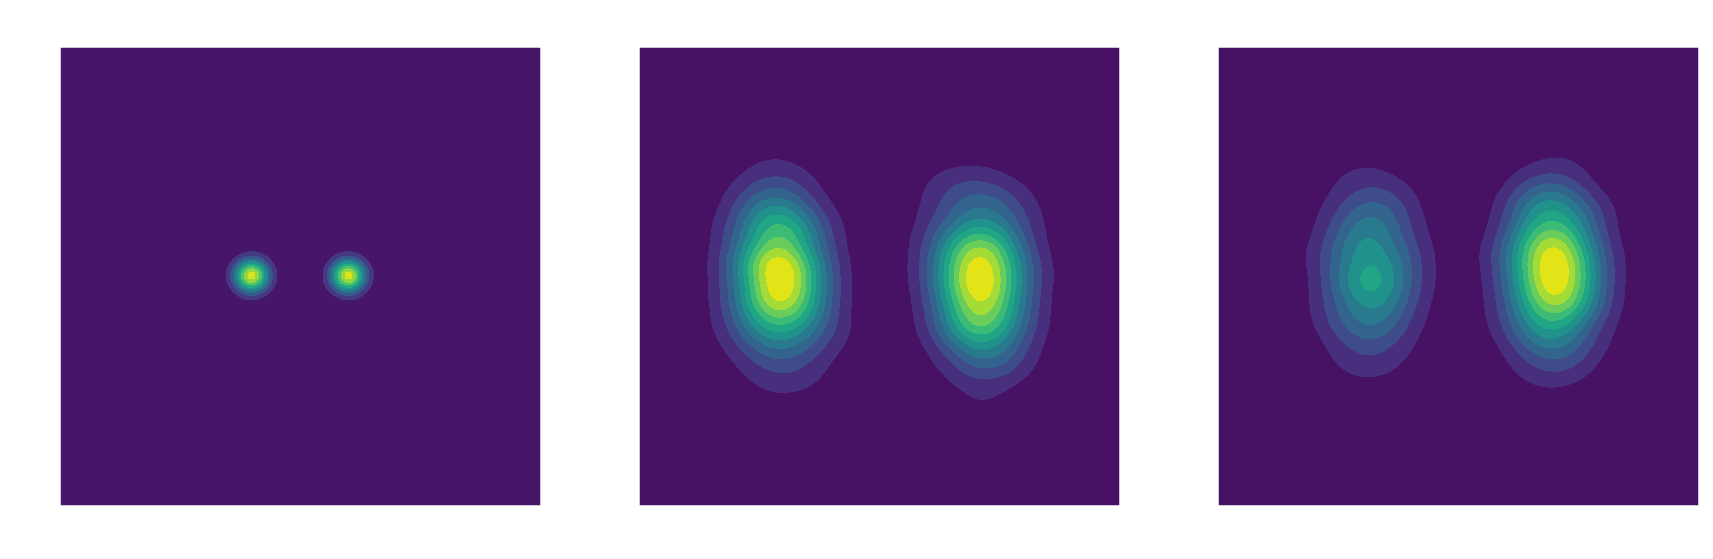

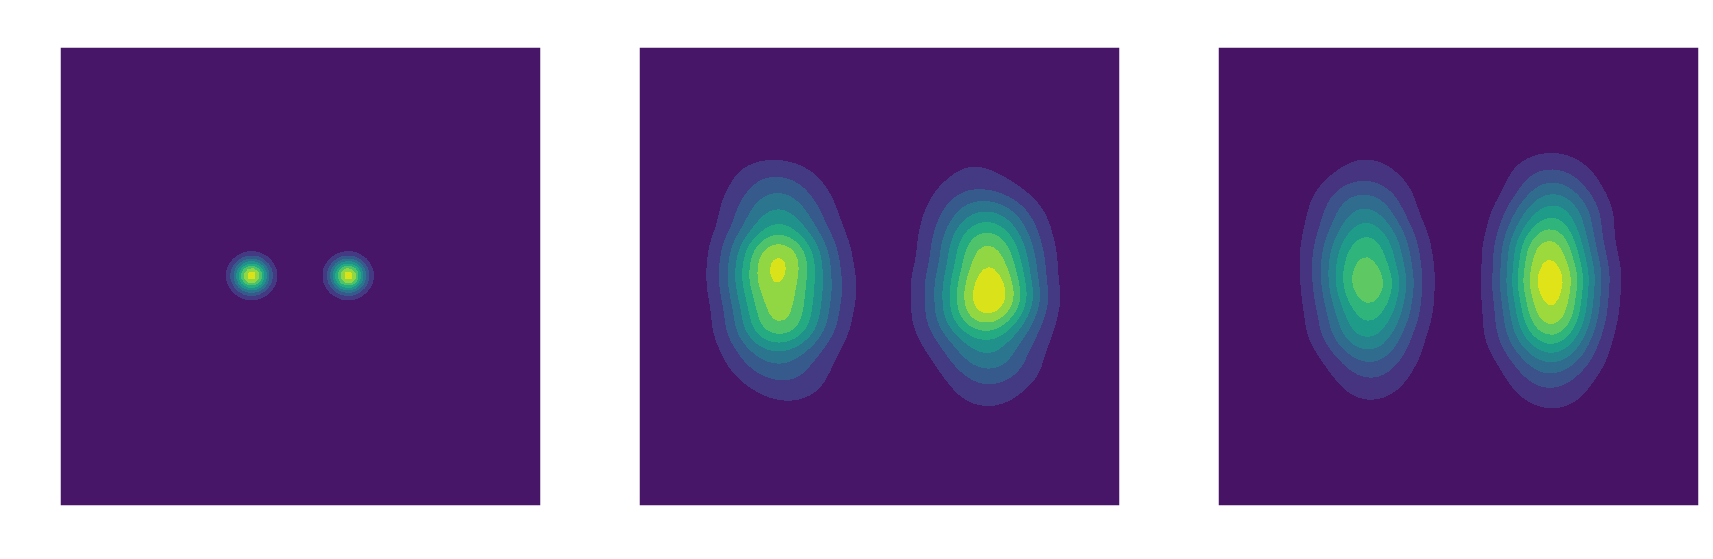

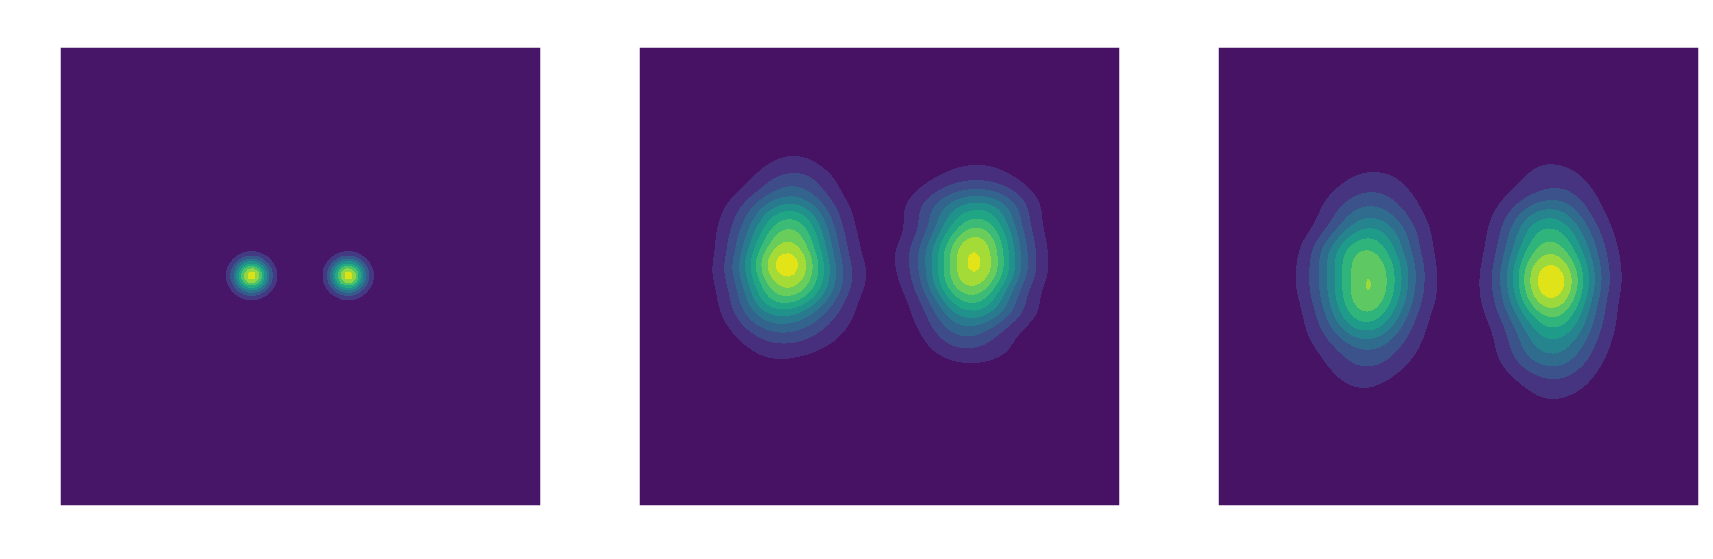

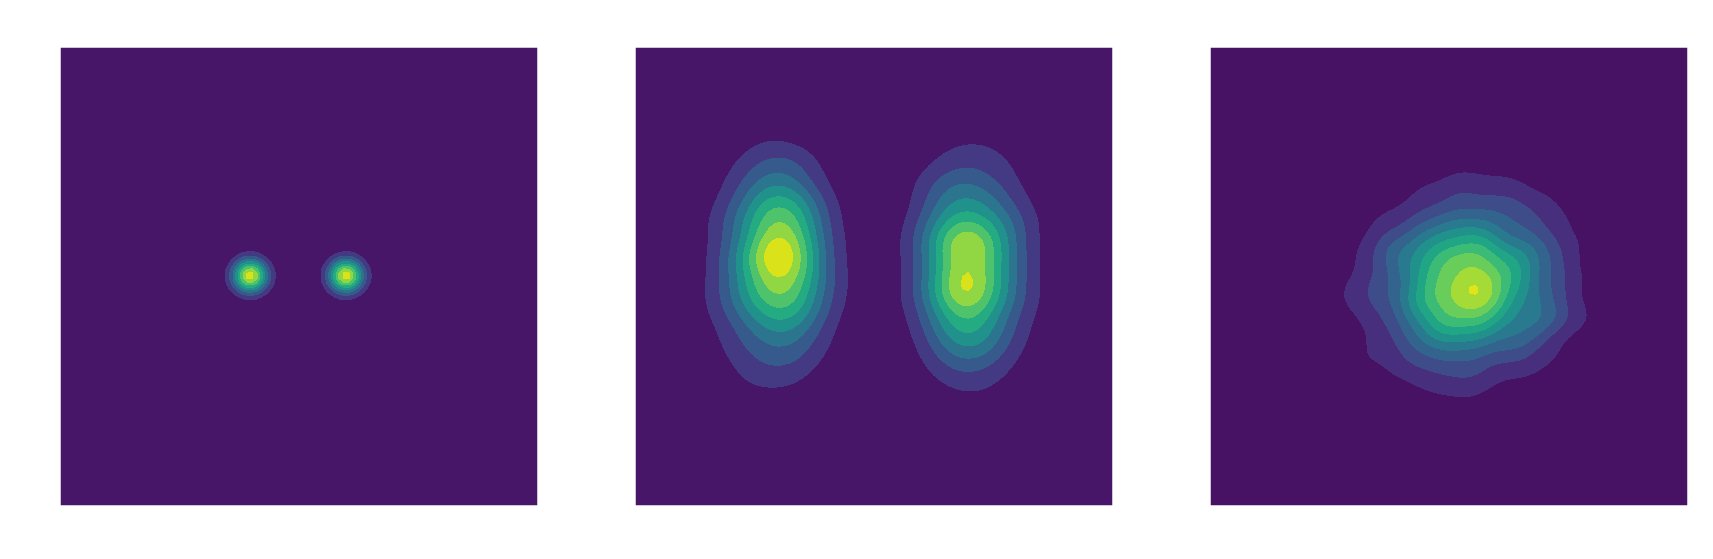

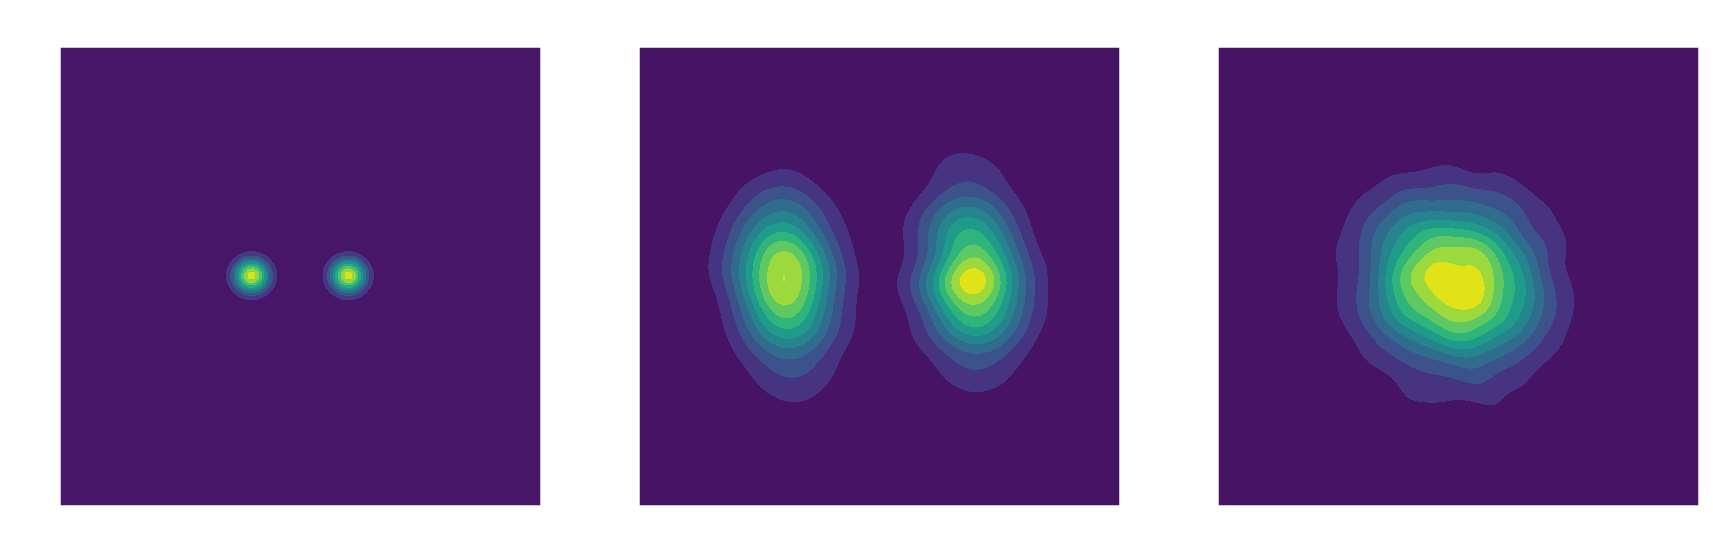

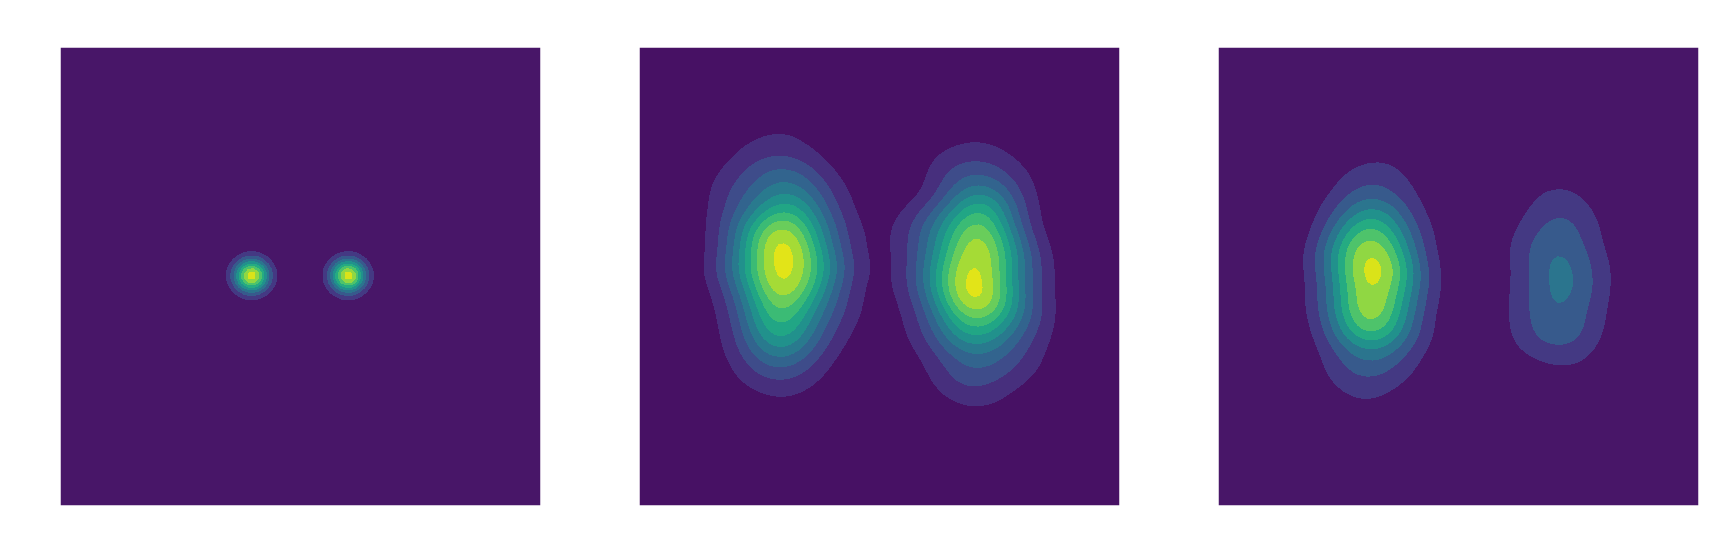

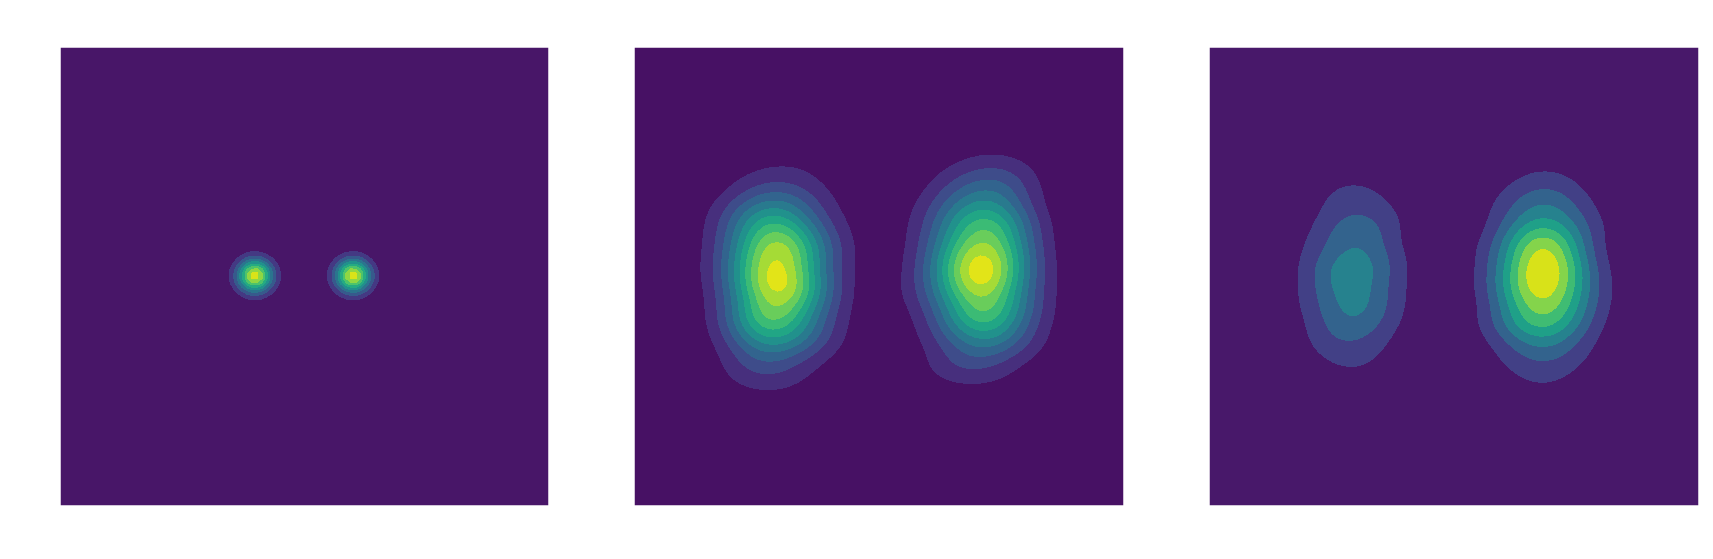

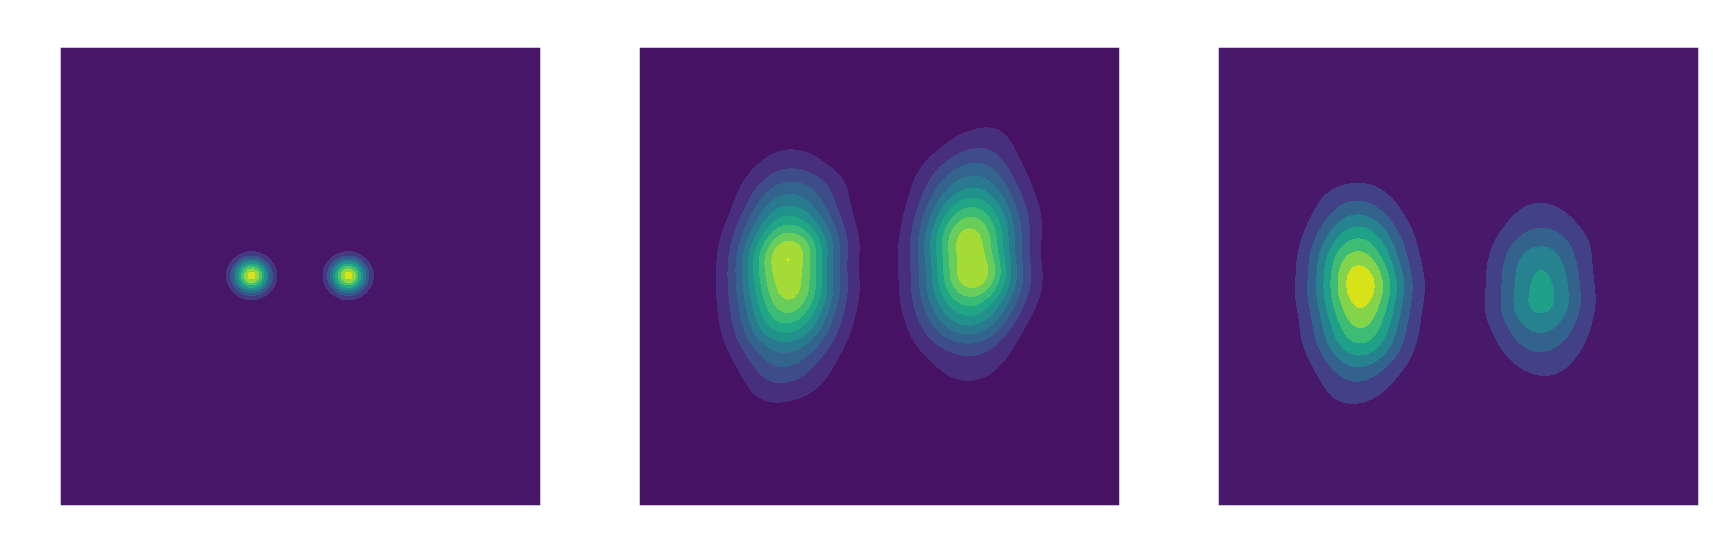

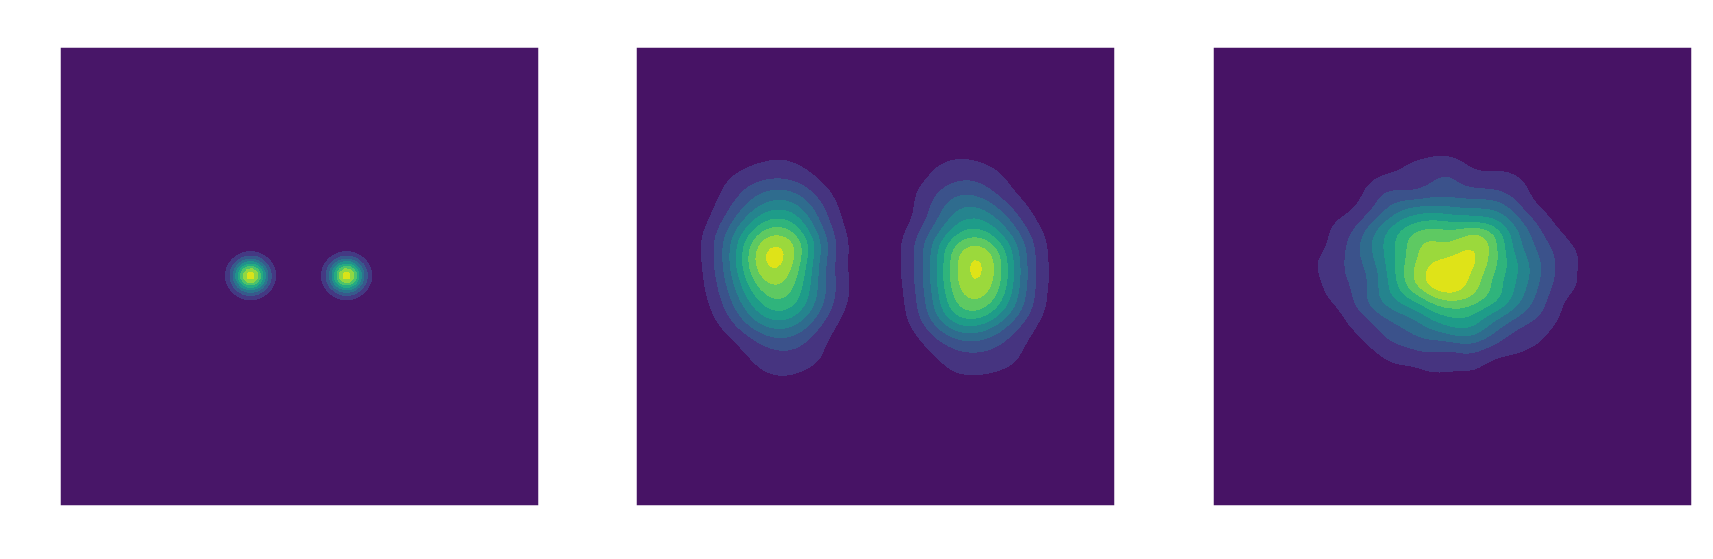

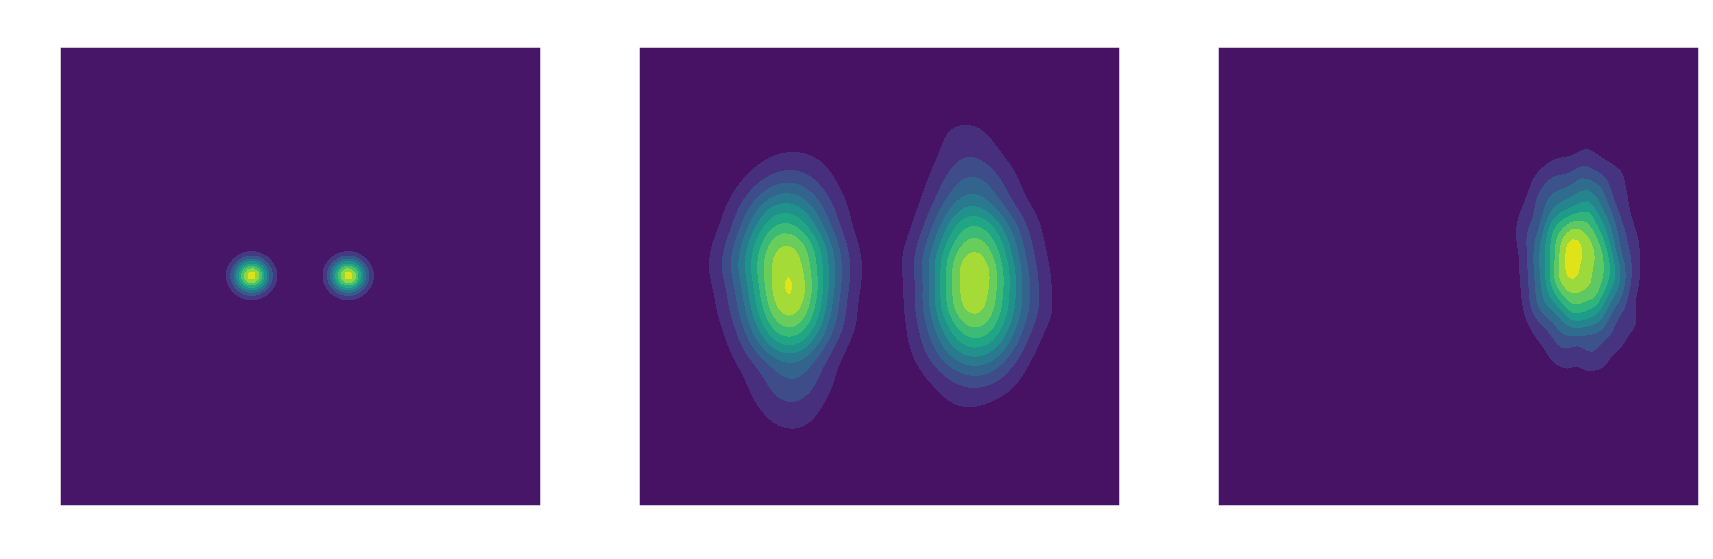

In [45]:
plot_density_estimation(dynamics.potential_fn, x_arr, x_arr_hmc,
                        num_plots=10, title=MODEL_TYPE, cmap='viridis')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

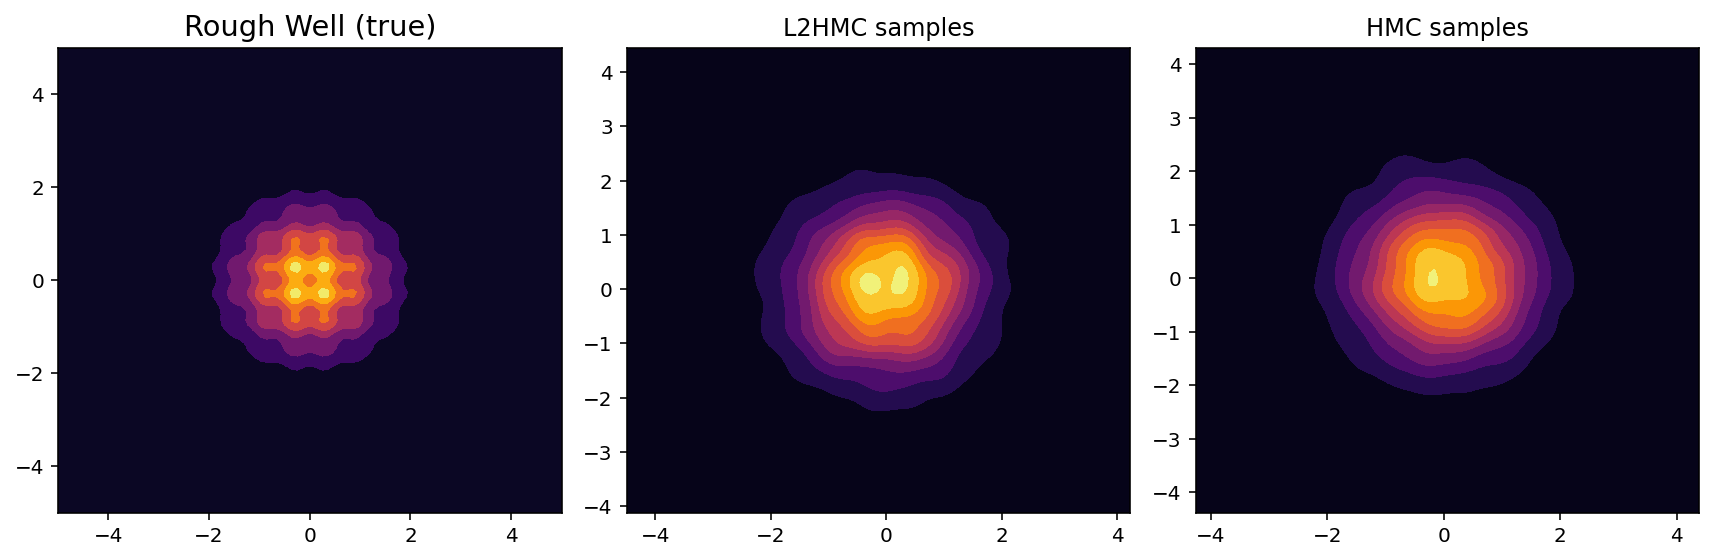

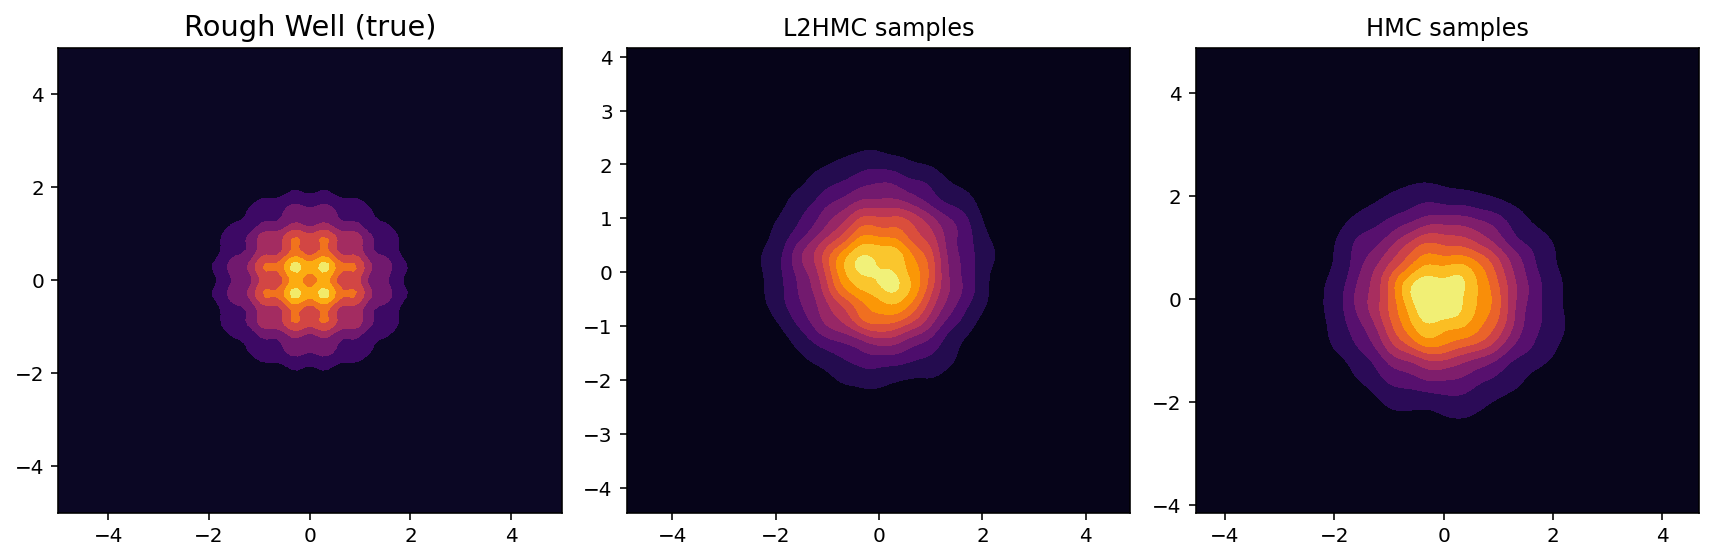

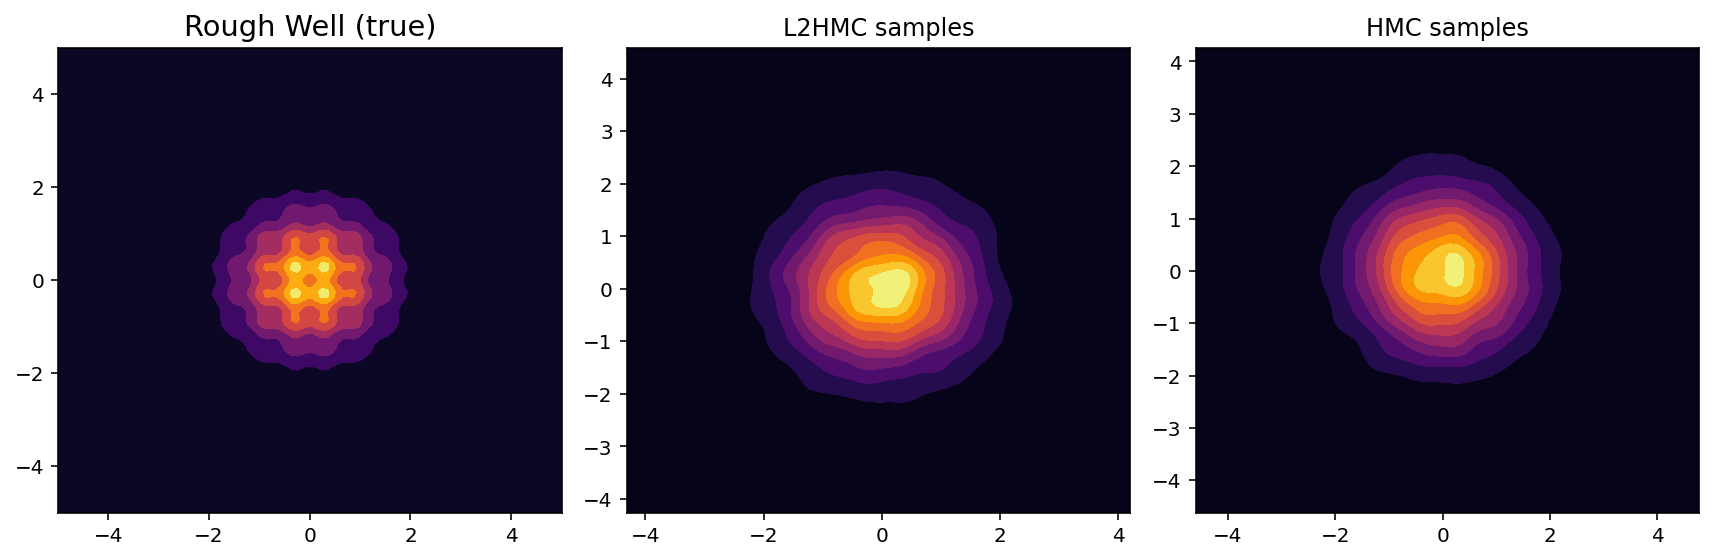

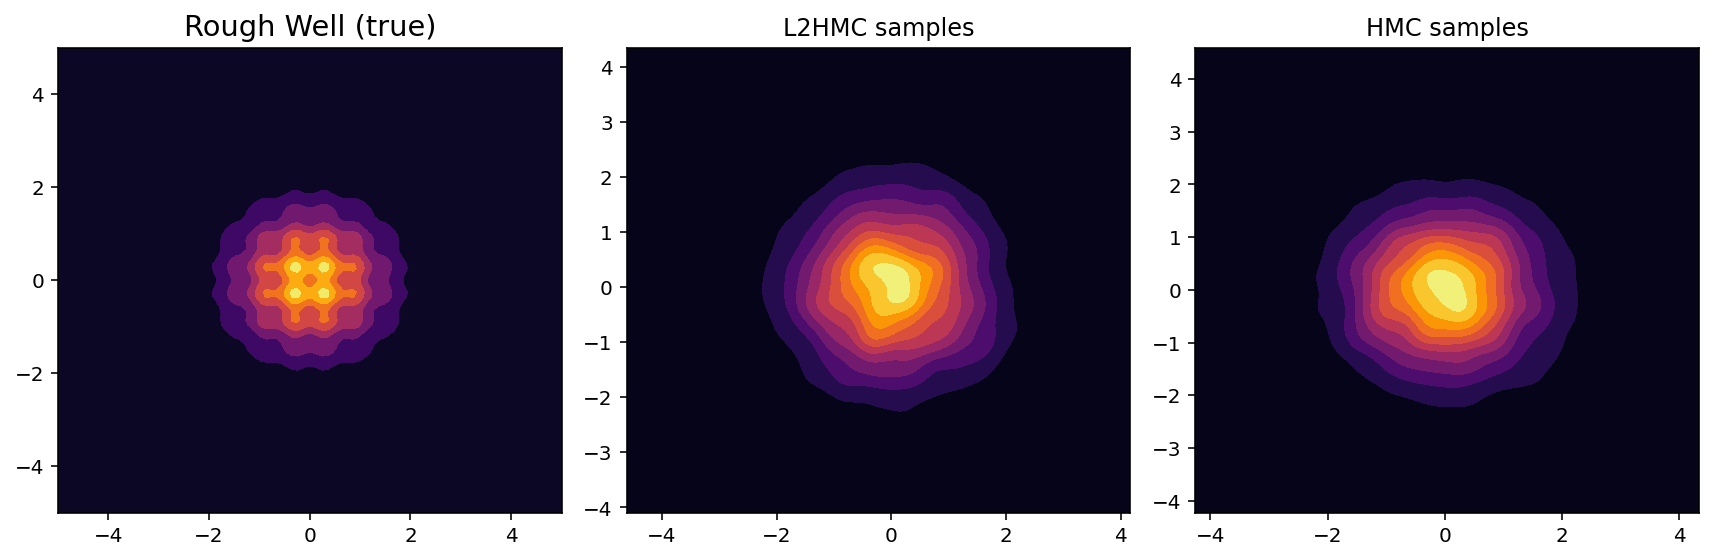

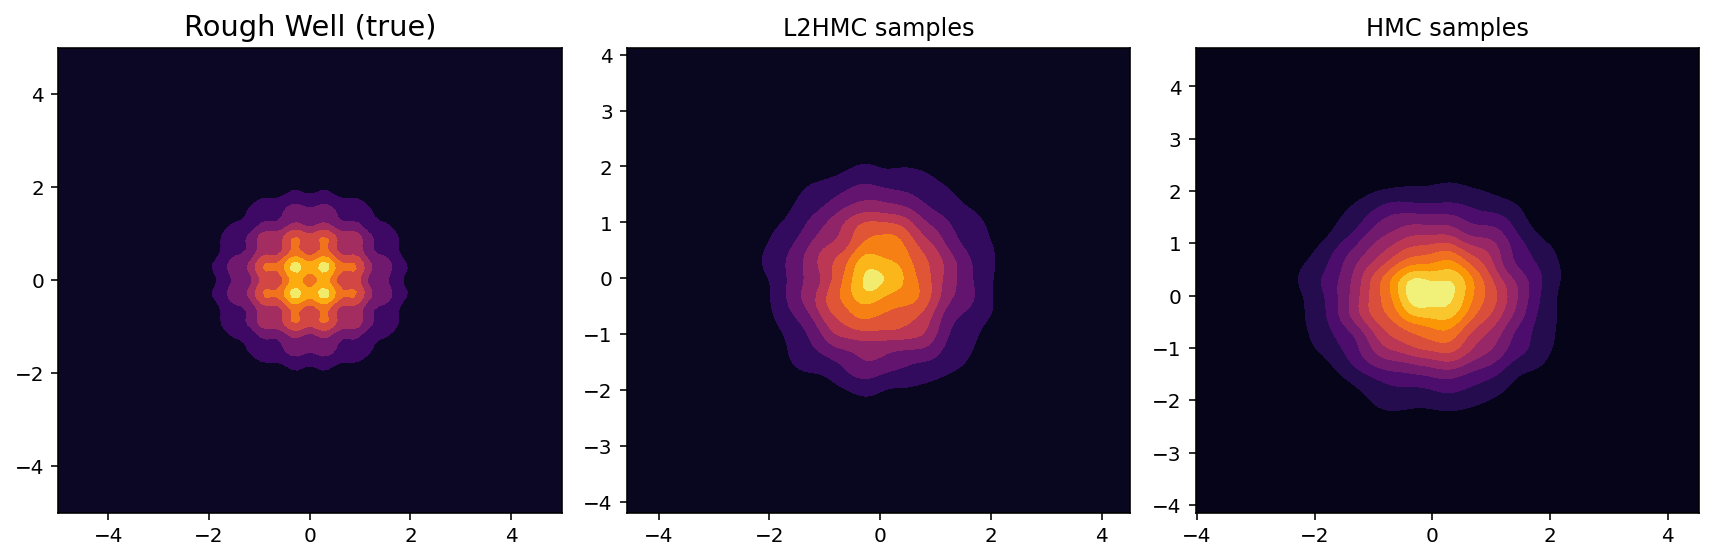

In [77]:
from utils.distributions import contour_potential
xl2hmc = np.array(x_arr)
xhmc = np.array(x_arr_hmc)

for idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    _ = contour_potential(POTENTIAL_FN, title='Rough Well (true)', ax=axes[0])
    _ = sns.kdeplot(xl2hmc[:, idx, 0], xl2hmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[1])
    _ = sns.kdeplot(xhmc[:, idx, 0], xhmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[2])
    _ = axes[1].set_title('L2HMC samples')
    _ = axes[2].set_title('HMC samples')
    plt.tight_layout()

### L2HMC Samples:

2020-08-31 14:43:10,703:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures
Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


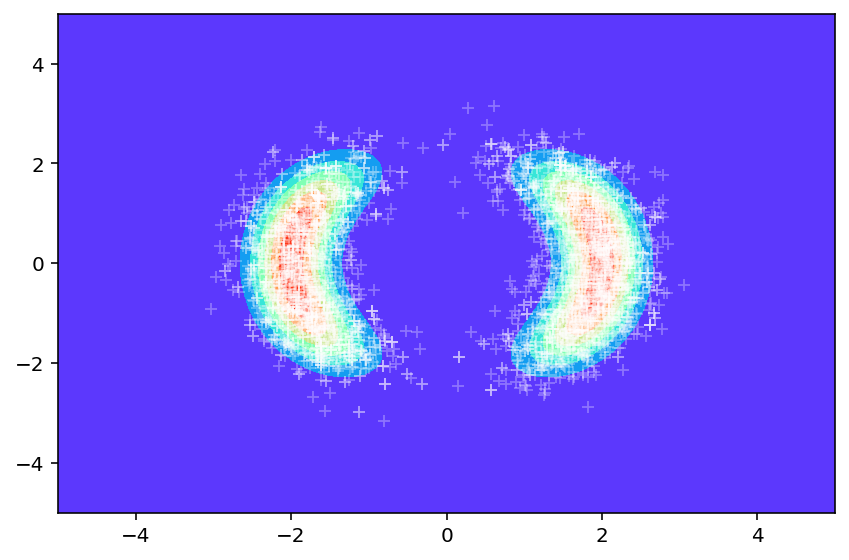

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


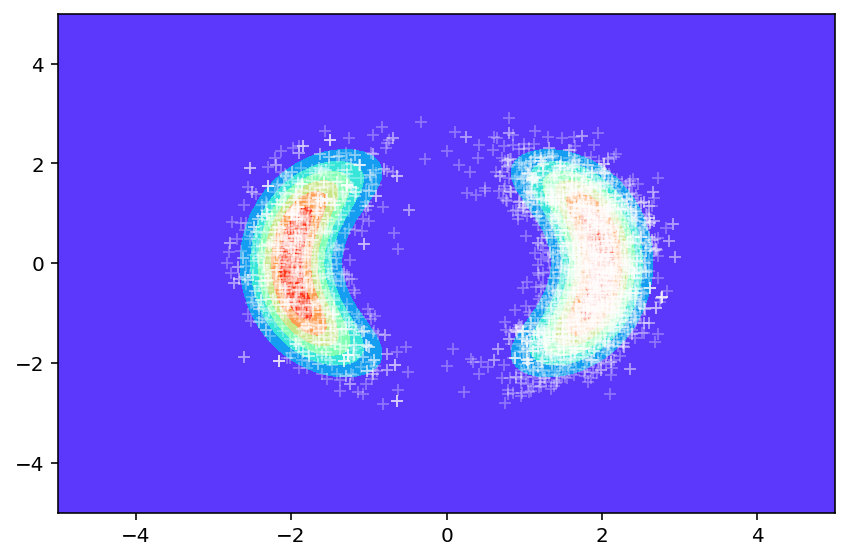

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


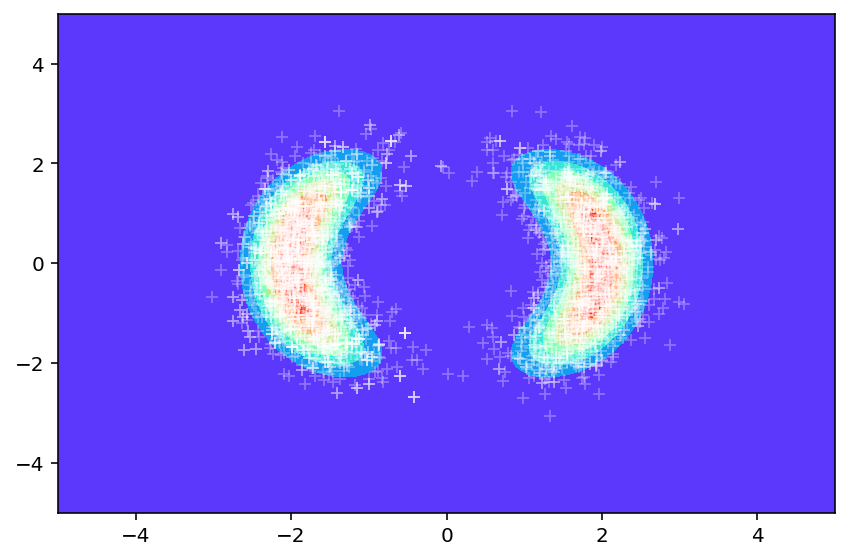

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


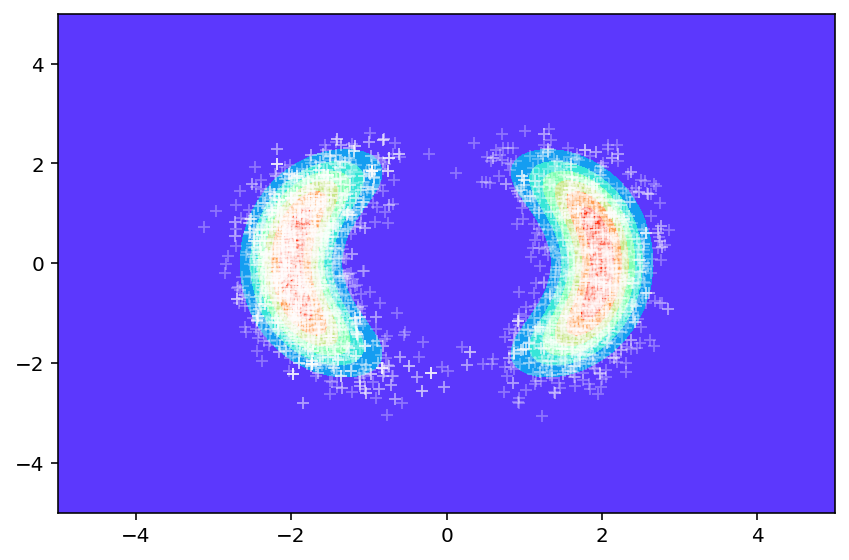

In [19]:
plot_chains(dirs, x_arr, POTENTIAL_FN, label='l2hmc samples', cmap='inferno')

### HMC Samples:

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain0.png


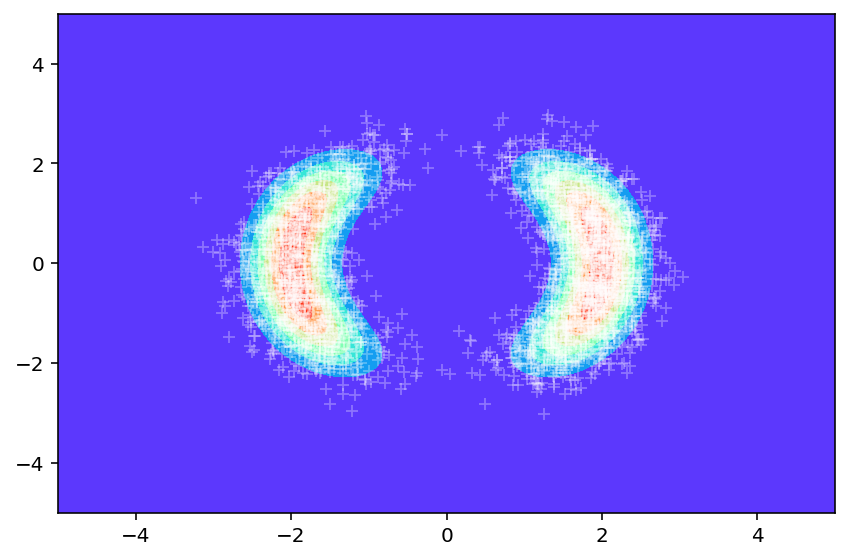

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain1.png


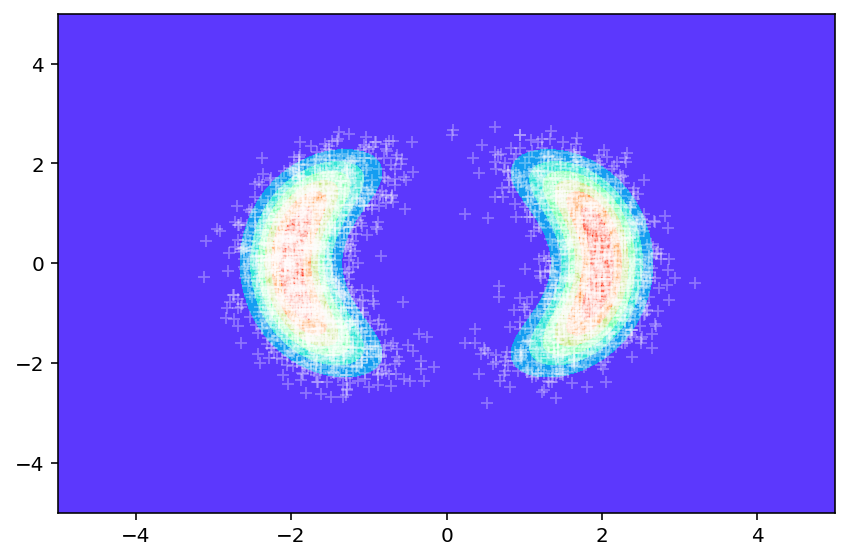

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain2.png


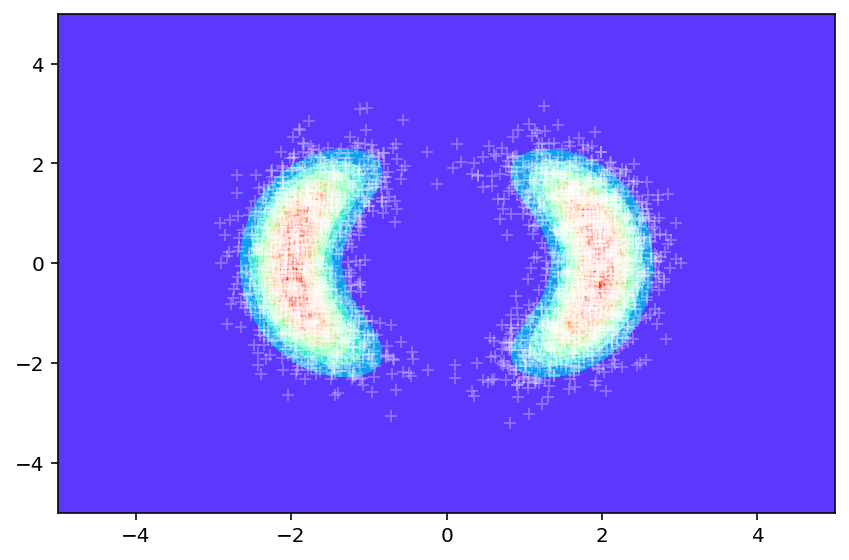

Saving figure to: /Users/saforem2/l2hmc-qcd/two_moons/2020-08-31/figures/trained_samples_chain3.png


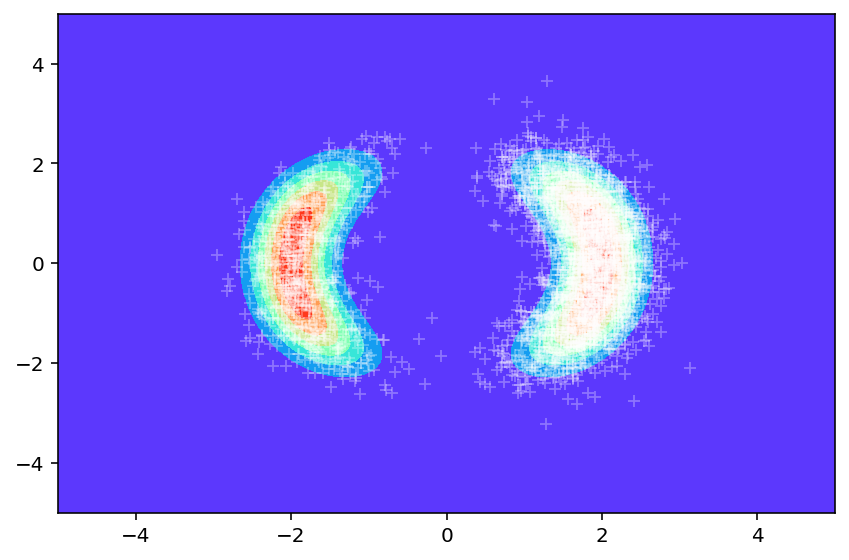

In [20]:
plot_chains(hmc_dirs, x_arr_hmc, POTENTIAL_FN, label='HMC samples', cmap='inferno')